# Dopamine modulation on BG

**Observation**: increase in beta-range spectral power is observed without dopamine modulation of CTX input to MSN-D1 and MSN-D2.

**Method**: I used the network model from Ortone and the model of dopamine modulation from Lindahl(2016). In particular, if an attribute $x$ of the network is subject to dopaminergic modulation, the effect of dopamine levels are modeled by

$$ x(\alpha) = x_0(1+\chi_x (\alpha -\alpha_0))$$
where $\alpha$ represents the dopamine level and $x_0$ is the value of the parameter at standard dopamine ($\alpha_0 = 0.8$, Lindahl). In the following, $\chi_x$ will be called generalized susceptibility.

The **main differences** between Ortone and Lindahl networks are:

- size of populations
- synaptic model
- cortical inputs: no AMPA/NMDA differentiation, different rates and weights
- STN subthreshold/suprathreshold adaptation parameter ada_a (Ortone: 0, Lindahl 0.3)
- Rest potential of FSN (Ortone: -80, Lindahl: -64.4). This attribute is negatively susceptible to dopamine, so FSN in Lindahl's network is already dopamine-depleted w.r.t. Ortone's network;
- SNr synaptic fan-in (from MSN-D1 Ortone: 59, Lindahl: 500; from GPeTI Ortone:25, Lindahl: 32 ). This is not particularly relevant for now since SNr is an output;

In [1]:
import yaml
from rich import print

NEURONS_FILE = "ortone_neurons.yaml"
NETWORK_FILE = "ortone_network.yaml"
DOPAMINE_FILE = "lindahl_dopamine_susceptibility_noctx_disentangled.yaml"

print("List of dopamine-dependent attributes:")
with open(DOPAMINE_FILE, "r") as dopfile:
    susceptiblities = yaml.safe_load(dopfile)['parametric']['dopamine']

for item in susceptiblities:
    if 'population' in item.keys():
        print(f"Attribute {item['attribute']:15} of population {item['population']:15}: chi = {item['susceptibility']}")
    elif 'projection' in item.keys():
        print(f"Attribute {item['attribute']:10} of projection {item['projection']:15}: chi = {item['susceptibility']}")

List of dopamine-dependent attributes:

Attribute E_l             of population FSN            : chi = -0.078

Attribute E_l             of population GPeTI          : chi = -0.181

Attribute E_l             of population GPeTA          : chi = -0.181

Attribute V_peak          of population D1             : chi = 0.0296

Attribute ada_b           of population D1             : chi = -0.45

Attribute E_l             of population SNR            : chi = -0.0896

Attribute weight     of projection FSN->FSN       : chi = -1.27

Attribute weight     of projection GPeTA->FSN     : chi = -0.53

Attribute weight     of projection GPeTI->FSN     : chi = -0.53

Attribute weight     of projection GPeTA->GPeTA   : chi = -0.83

Attribute weight     of projection GPeTA->GPeTI   : chi = -0.83

Attribute weight     of projection GPeTI->GPeTI   : chi = -0.83

Attribute weight     of projection GPeTI->GPeTA   : chi = -0.83

Attribute weight     of projection D2->GPeTI      : chi = -0.83

Attribute weight     of projection STN->GPeTA     : chi = -0.45

Attribute weight     of projection STN->GPeTI     : chi = -0.45

Attribute connectivity of projection FSN->D2        : chi = -0.9

Attribute connectivity of projection D1->D1         : chi = 0.88

Attribute connectivity of projection D1->D2         : chi = 0.88

Attribute connectivity of projection D2->D1         : chi = 0.88

Attribute connectivity of projection D2->D2         : chi = 0.88

Attribute weight     of projection D1->D1         : chi = 0.88

Attribute weight     of projection D1->D2         : chi = 0.88

Attribute weight     of projection D2->D1         : chi = 0.88

Attribute weight     of projection D2->D2         : chi = 0.88

Attribute weight     of projection GPeTA->D1      : chi = -1.15

Attribute weight     of projection D1->SNR        : chi = 0.56

Attribute weight     of projection GPeTI->STN     : chi = -0.24

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext wurlitzer
%matplotlib inline
# %matplotlib ipympl

## Parameters of the simulation

In [3]:
Tlong = 8000  # ms
dt = 0.1      # ms

points_per_bin = 1/dt     # bins 1 ms wide
sampling_frequency = 1e3  # 1 kHz sampling frequency
burn_in_millis = 600      # the first part of the record to discard (ms)

# Params for trials
n_trials = 10
Tshort = 1500 # ms

# Rescaling of populations: Lindahl network is unbearable on my machine
# so populations are rescaled to match sizes from Ortone
populations_scaling = dict()
if NETWORK_FILE == "lindahl_network.yaml":
    populations_scaling = dict( MSN_scale= -0.84,
                                FSN_scale= -0.74,
                                GPe_scale= -0.22,
                                STN_scale= 0.05
                                )

reasonable_firing = dict(FSN=15, D1=1.5, D2=1.5, GPeTI=50, GPeTA=10, STN=16)
# FSN [10-20] Hz 
# D1, D2 [0.5–2.5] Hz
# GPe-TI [40–60] Hz
# GPe-TA [5–15] Hz 
# and STN [12–20] Hz


## Utils & plots

In [4]:
from scipy.signal import butter, sosfiltfilt, freqz, welch
from scipy.integrate import simpson
from scipy import stats

def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data('spikes')
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    T = len(binned_spikes)
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = T/2, # Takes at least 3 windows
                   noverlap= T/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')

    beta_mask = (f>=12)&(f<30)
    low_gamma_mask = (f>=30)&(f<50)
    high_gamma_mask = (f>=50)&(f<90)
    
    norm_beta = simpson(PSD[beta_mask], x=f[beta_mask])
    fmean = simpson(f[beta_mask]*PSD[beta_mask]/norm_beta, x=f[beta_mask])

    spectral_norm = simpson(PSD, x=f)
    result = dict(
        fmax = f[np.argmax(PSD)],
        fmean=fmean,
        
        norm_beta_power=simpson(PSD[beta_mask], x=f[beta_mask])/spectral_norm,
        norm_low_gamma_power=simpson(PSD[low_gamma_mask], x=f[low_gamma_mask])/spectral_norm,
        norm_high_gamma_power=simpson(PSD[high_gamma_mask], x=f[high_gamma_mask])/spectral_norm,

        beta_power = simpson(PSD[beta_mask], x=f[beta_mask]),
        low_gamma_power = simpson(PSD[low_gamma_mask], x=f[low_gamma_mask]),
        high_gamma_power = simpson(PSD[high_gamma_mask], x=f[high_gamma_mask]),

        entropy=stats.entropy(PSD/spectral_norm),
    )
    
    return result

def firing_rate(sn, population):
    binned_spikes = bin_spikes(sn.populations[population].get_data('spikes'))
    instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
    return np.mean(instantaneous_fr)

def bandpass(data, edges, sample_rate, poles = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

def get_PSD(sn, pop, frequency_resolution=0.5, smooth=False):
    spikes = sn.populations[pop].get_data('spikes')
    binned_spikes = bin_spikes(spikes)
    binned_spikes = binned_spikes[burn_in_millis:]
    T = len(binned_spikes)
    # print(f"Mean firing rate {pop} is {np.sum(spikes)/sn.populations[pop].n_neurons/(Tlong/1000) :.1f} Hz")

    N = sampling_frequency/frequency_resolution
    
    if N > T/2:
        print(N)
        print(f"Not enough points to achieve resolution of {frequency_resolution}")
        N = T/2

    nfft = 10_000 if smooth else None
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg=N, 
                   noverlap=N/2,
                   nfft=nfft,
                   scaling='density', 
                   window='hamming')
    # print(f"F resolution { f[1] - f[0] :.2f} Hz")
    norm = simpson(PSD, x=f)
    return f, PSD

In [5]:
def plot_spectrum(sn, scale="log", pops=None):
    if pops is None:
        pops = sn.populations
    fig, axes = plt.subplots(len(pops), 1, sharex=True)
    for ax, pop in zip(axes, pops):
        f, PSD = get_PSD(sn, pop)
        norm = simpson(PSD, x=f)
        ax.plot(f, PSD/norm, label=pop)
        
        ax.set_ylabel(pop)
        ax.set_yscale(scale)
    # print(f"F resolution { f[1] - f[0] :.2f} Hz")
    # plt.yscale('log')
    # plt.legend()
    # plt.ylabel("normalized PSD")
    plt.xlabel("Frequency [Hz]")
    plt.xlim(10, 30)
    fig.set_figheight(8.5)
    return fig

def plot_signals(sn, pops=None):
    if pops is None:
        pops = sn.populations.keys()
    colors = sns.color_palette("rainbow", 10)

    fig, ax = plt.subplot_mosaic([[pop] for pop in pops],sharex=True, figsize=(8,2*len(pops)))

    for pop in pops:    
        binned_spikes = bin_spikes(sn.populations[pop].get_data('spikes'))
        instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
        
        tt = np.linspace(0, len(instantaneous_fr)/1000, len(instantaneous_fr))
        ax[pop].plot(tt, instantaneous_fr, color="#c3c3c3", label="raw")
            
        ax[pop].plot(tt,np.mean(instantaneous_fr) + bandpass(instantaneous_fr, [12, 30], sampling_frequency), label=r"$\beta$", color=colors[9])
        ax[pop].plot(tt, np.mean(instantaneous_fr)  + bandpass(instantaneous_fr, [30, 90], sampling_frequency), label=r"$\gamma$", color=colors[2])
        
        ax[pop].set_xlim(6, 7)
        ax[pop].set_ylabel(f"{pop} [Hz]")
        ax[pop].legend()
    
    leg = ax[pops[0]].get_legend()
    for a in ax.values():
        a.legend().remove()
    
    fig.legend(handles=leg.legend_handles, loc='upper right')
    
    ax[pops[-1]].set_xlabel("time [s]")
    return fig


## Building the network

In [6]:
from quilt.interface.base import set_verbosity
set_verbosity(2)

In [7]:
from quilt.builder import NeuronCatalogue, ParametricSpikingNetwork

sn = ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
                                        NEURONS_FILE,
                                        [DOPAMINE_FILE], 
                                         # DISPERSION_FILE, "dbs.yaml"]
                                       )
sn.monitorize_spikes()
# sn.monitorize_states("GPeTA")

## Control case (healthy subject)

In [8]:
sn.set_parameters(dopamine=1.0)
sn.run(dt=dt, time=Tshort)

[2024-07-13 15:35:15] - PID 139275723146368 - INFO: Evolving spiking network from t= 0 to t= 1500
Running network consisting of 14622 neurons for 15000 timesteps
--------------------------------------------------
**************************************************
[2024-07-13 15:35:32] - PID 139275723146368 - INFO: Ouput for PerformanceRegistrar (8 managers )
[2024-07-13 15:35:32] - PID 139275723146368 - INFO: Output for PerformanceManager <spiking network>
_________inject _____2.1 s | 140.0 us/step for 15001 steps
_____monitorize __879.0 us | _58.0 ns/step for 15001 steps
_____simulation ____17.1 s

[2024-07-13 15:35:32] - PID 139275723146368 - INFO: Output for PerformanceManager <Population 0>
______evolution _____3.8 s | 253.2 us/step for 15001 steps | _42.0 ns/step/unit for 15001 steps and 6000 units
_spike_emission __428.3 ms | _28.5 us/step for 15001 steps | __4.0 ns/step/unit for 15001 steps and 6000 units
_spike_handling __681.5 ms | _45.4 us/step for 15001 steps | __7.0 ns/step

(0.0, 1.5)

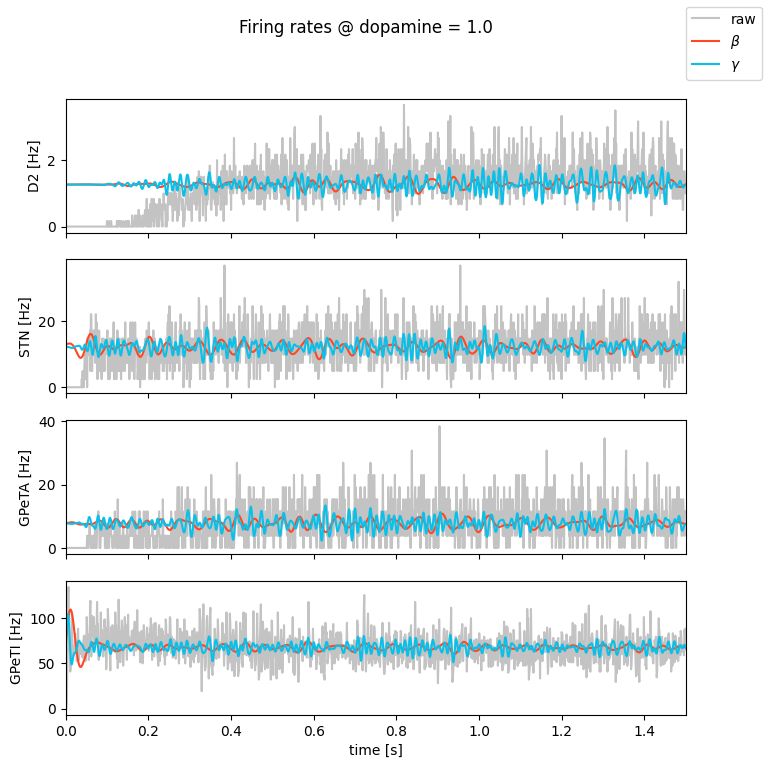

In [13]:
plot_signals(sn, pops=['D2', 'STN', 'GPeTA', 'GPeTI']);
plt.gcf().suptitle('Firing rates @ dopamine = 1.0');
plt.gca().set_xlim(0, 1.5)

2000.0

Not enough points to achieve resolution of 0.5

2000.0

Not enough points to achieve resolution of 0.5

2000.0

Not enough points to achieve resolution of 0.5

2000.0

Not enough points to achieve resolution of 0.5

2000.0

Not enough points to achieve resolution of 0.5

2000.0

Not enough points to achieve resolution of 0.5

2000.0

Not enough points to achieve resolution of 0.5

(0.0, 500.0)

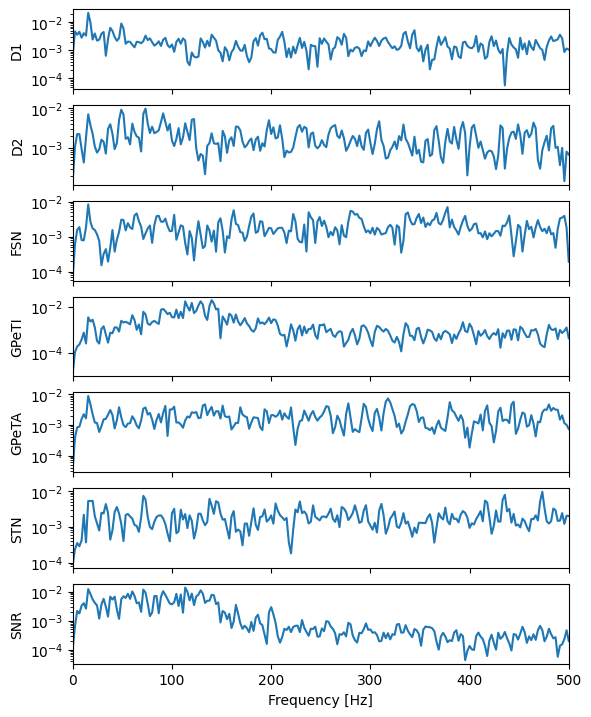

In [10]:
plot_spectrum(sn)
plt.gca().set_xlim(0, 500)

## Lesioned case (PD)

In [14]:
sn.set_parameters(dopamine=0.0)
sn.run(dt=dt, time=Tlong)

[2024-07-13 15:37:21] - PID 139275723146368 - INFO: Evolving spiking network from t= 0 to t= 8000
Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
[2024-07-13 15:39:09] - PID 139275723146368 - INFO: Ouput for PerformanceRegistrar (8 managers )
[2024-07-13 15:39:09] - PID 139275723146368 - INFO: Output for PerformanceManager <spiking network>
_________inject ____13.2 s | 164.7 us/step for 80000 steps
_____monitorize ____6.4 ms | _79.0 ns/step for 80000 steps
_____simulation ___108.3 s

[2024-07-13 15:39:09] - PID 139275723146368 - INFO: Output for PerformanceManager <Population 0>
______evolution ____24.4 s | 305.3 us/step for 80000 steps | _50.0 ns/step/unit for 80000 steps and 6000 units
_spike_emission _____3.9 s | _48.2 us/step for 80000 steps | __8.0 ns/step/unit for 80000 steps and 6000 units
_spike_handling _____4.6 s | _57.8 us/step for 80000 steps | __9.0 ns/step

(7.0, 8.0)

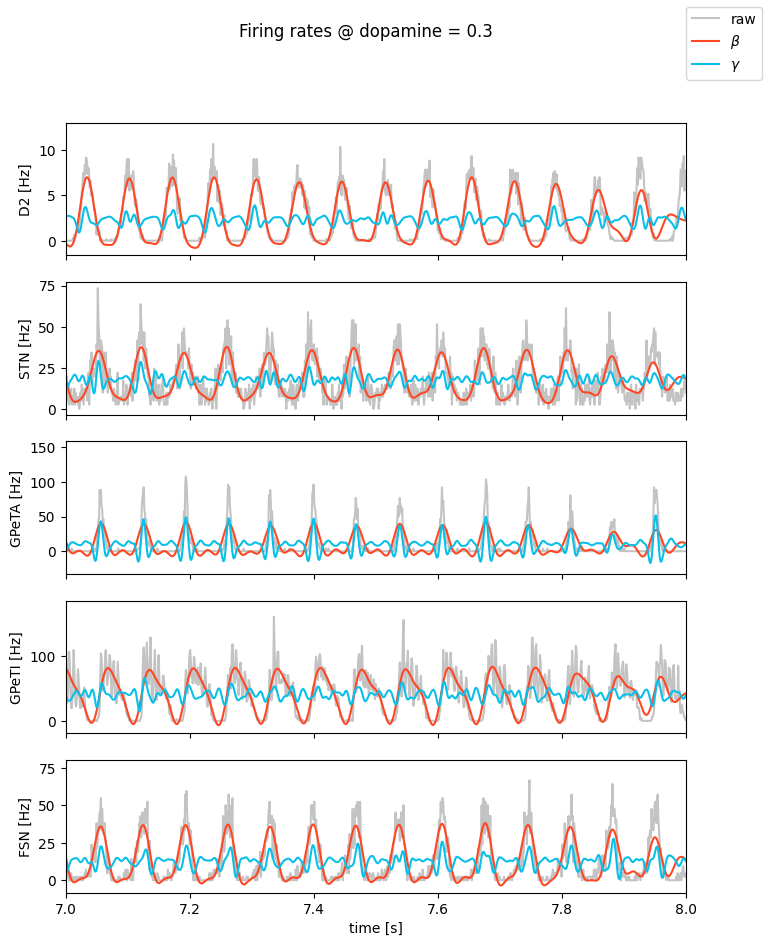

In [15]:
plot_signals(sn, pops=['D2', 'STN', 'GPeTA', 'GPeTI', 'FSN']);
plt.gcf().suptitle('Firing rates @ dopamine = 0.3');
plt.gca().set_xlim(7, 8)

## Comparison

In [104]:
dopamines = [0.0, 0.3, 0.6]

nets = []
for dopamine in dopamines:
    nets.append(ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
                                            NEURONS_FILE,
                                            [DOPAMINE_FILE]))
    nets[-1].set_parameters(dopamine=dopamine)
    nets[-1].monitorize_spikes()

In [105]:
for net in nets:
    net.run(dt=dt, time=Tlong)

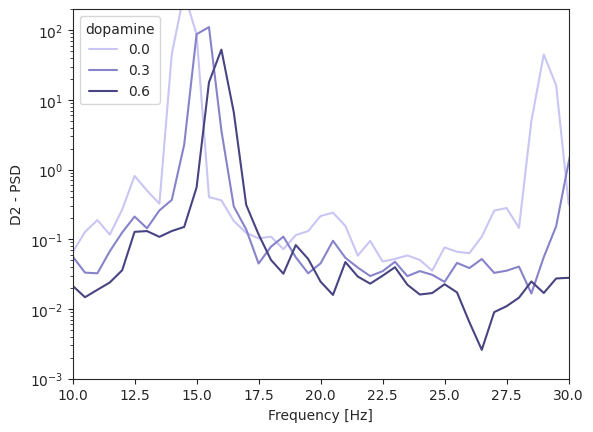

In [108]:
fig, ax = plt.subplots()
D2_colors = sns.cubehelix_palette(start=0, rot=0, dark=0.3, light=0.8, reverse=False, n_colors=len(nets), hue=1)
STN_colors = sns.cubehelix_palette(start=1.3, rot=0, dark=0.3, light=0.8, reverse=False, n_colors=len(nets), hue=1)

sns.set_style("ticks")

for i in range(len(nets)):
    ax.plot(*get_PSD(nets[i], "D2", frequency_resolution=0.5, smooth=False), label=dopamines[i], color=D2_colors[i])

ax.set_yscale('log')
ax.set_xlim(10, 30)
plt.legend(title="dopamine")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("D2 - PSD")
ax.set_ylim(1e-3, 2e2)
plt.savefig("images/D2-PSD.pdf")

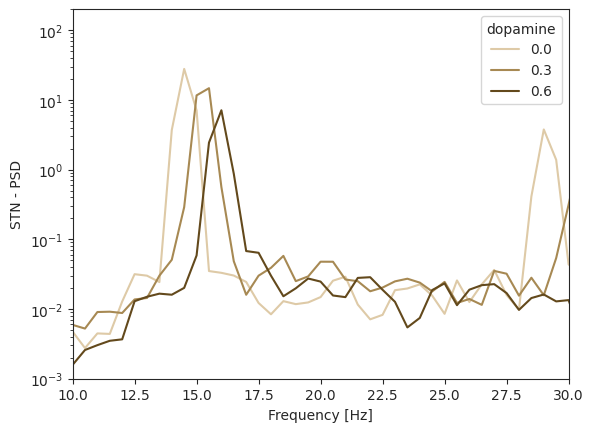

In [110]:
fig, ax = plt.subplots()
STN_colors = sns.cubehelix_palette(start=1.3, rot=0, dark=0.3, light=0.8, reverse=False, n_colors=len(nets), hue=1)

sns.set_style("ticks")

for i in range(len(nets)):
    ax.plot(*get_PSD(nets[i], "STN", frequency_resolution=0.5, smooth=False), label=dopamines[i], color=STN_colors[i])
    # ax.plot(*get_PSD(nets[i], "STN"), label="STN", color=STN_colors[i])
ax.set_yscale('log')
ax.set_xlim(10, 30)
plt.legend(title="dopamine")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("STN - PSD")
ax.set_ylim(1e-3, 2e2)
plt.savefig("images/STN-PSD.pdf")

## Trend

In [27]:
from rich.progress import track

set_verbosity(0)
beta_powers = dict()
fmaxs = dict()
beta_powers_normalized = dict()
entropies = dict()

for pop in sn.spike_monitored_pops:
    fmaxs[pop] = []
    beta_powers[pop] = []
    beta_powers_normalized[pop] = []
    entropies[pop] = []
    
dopamine_levels = np.linspace(0.2, 0.9, 20)

for dopamine in track(dopamine_levels, total=len(dopamine_levels)):
    sn.set_parameters(dopamine=dopamine)
    sn.run(dt=dt, time=1600)
    for pop in sn.populations.keys():
        fmax, normbeta, beta, entropy = beta_power(sn, pop)
        fmaxs[pop] += [fmax]
        beta_powers_normalized[pop] += [normbeta]
        beta_powers[pop] += [beta]
        entropies[pop] += [entropy]

Output()

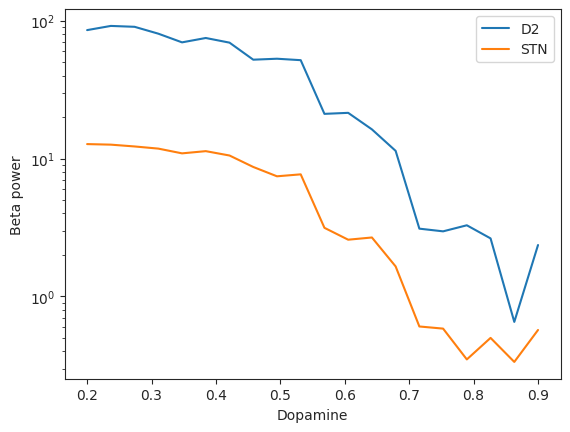

In [35]:
for pop in ["D2", "STN"]:
    plt.plot(dopamine_levels, beta_powers[pop], label=pop)
plt.ylabel("Beta power")
plt.xlabel("Dopamine")
plt.yscale('log')
plt.legend()

(13.0, 17.0)

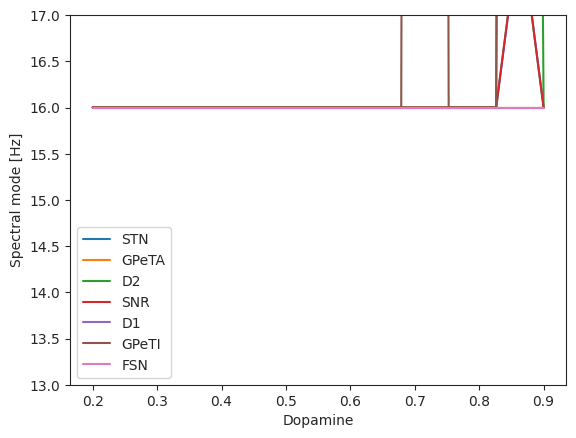

In [34]:
for pop in fmaxs:
    plt.plot(dopamine_levels, fmaxs[pop], label=pop)
# plt.yscale('log')
plt.ylabel("Spectral mode [Hz]")
plt.xlabel("Dopamine")
plt.legend()
plt.ylim(13, 17)

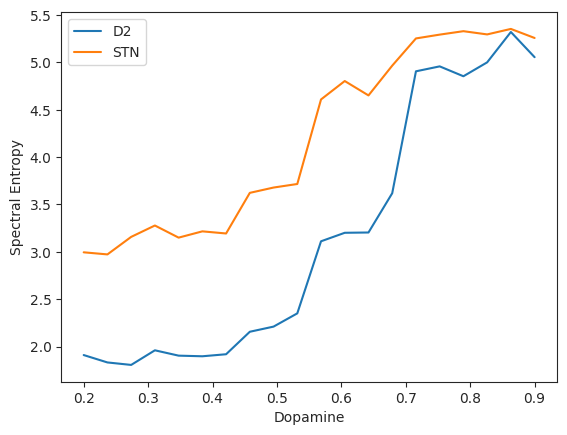

In [30]:
for pop in ["D2", "STN"]:
    plt.plot(dopamine_levels, entropies[pop], label=pop)
# plt.yscale('log')
plt.xlabel("Dopamine")
plt.ylabel("Spectral Entropy")
plt.legend()

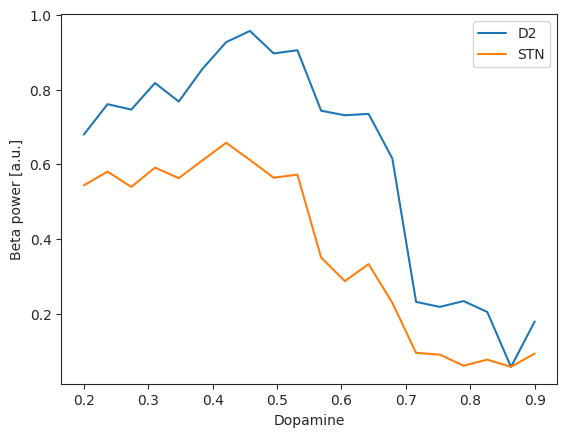

In [31]:
for pop in ["D2", "STN"]:
    plt.plot(dopamine_levels, beta_powers_normalized[pop], label=pop)
# plt.yscale('log')
plt.ylabel("Beta power [a.u.]")
plt.xlabel("Dopamine")
plt.legend()

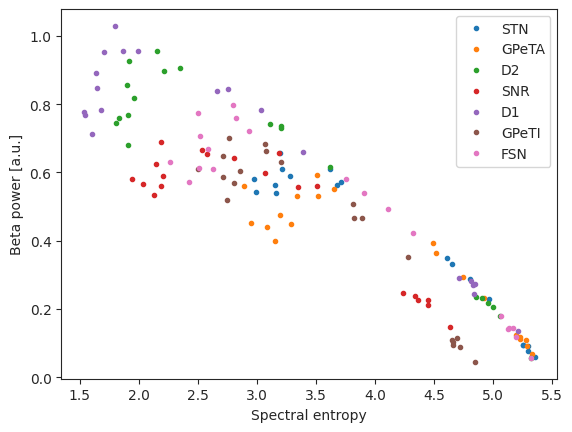

In [32]:
for pop in beta_powers_normalized:
    plt.plot(entropies[pop], beta_powers_normalized[pop], label=pop, ls="", marker=".")
plt.xlabel("Spectral entropy")
plt.ylabel("Beta power [a.u.]")
plt.legend()

## plot 2D

In [98]:
from scipy.integrate import simpson
def bin_spectrum(f, PSD, n_bins=20, fmax=90):
    norm = simpson(PSD[f<fmax], x=f[f<fmax])
    
    binned_spectrum = np.zeros(n_bins)
    frequency_bin_width = fmax/n_bins
    for i in range(n_bins):
        f_mask = (f > i*frequency_bin_width)&(f < (i+1)*frequency_bin_width)
        # binned_spectrum[i] = simpson(PSD[f_mask], x=f[f_mask])/norm
    return binned_spectrum

In [97]:
from rich.progress import track

set_verbosity(0)

spectral_resolution = 1
N_dopamine_levels = int(90/spectral_resolution)
N_spectral_bins = int(90/spectral_resolution)
dopamine_levels = np.linspace(0.0, 1.0, N_dopamine_levels)

spectra = dict()
for pop in sn.populations:
    spectra[pop] = np.zeros((N_dopamine_levels, N_spectral_bins))

for i in track(range(N_dopamine_levels), total=len(dopamine_levels)):
    sn.set_parameters(dopamine=dopamine_levels[i])
    sn.run(dt=dt, time=3 * sampling_frequency/spectral_resolution + burn_in_millis ) # Uses 3 complete windows at minimal resolution
    for pop in sn.populations.keys():
        f, PSD = get_PSD(sn, pop, frequency_resolution=spectral_resolution)
        plt.show()
        spectra[pop][i] = PSD[f<90]
    

Output()

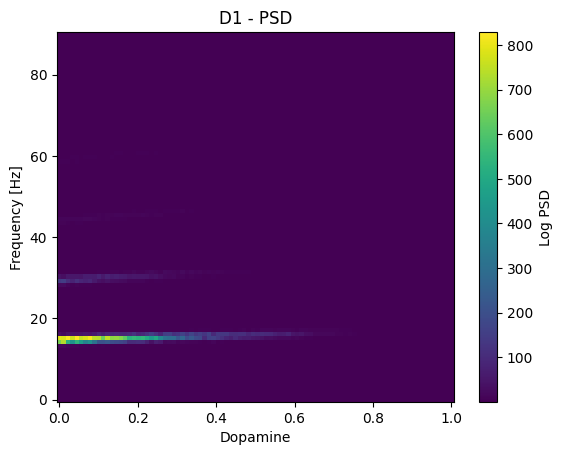

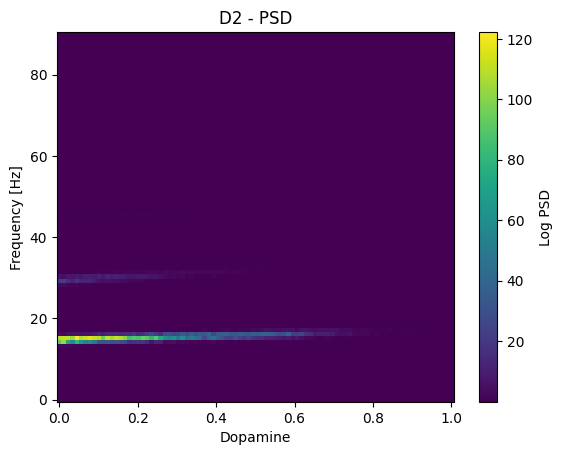

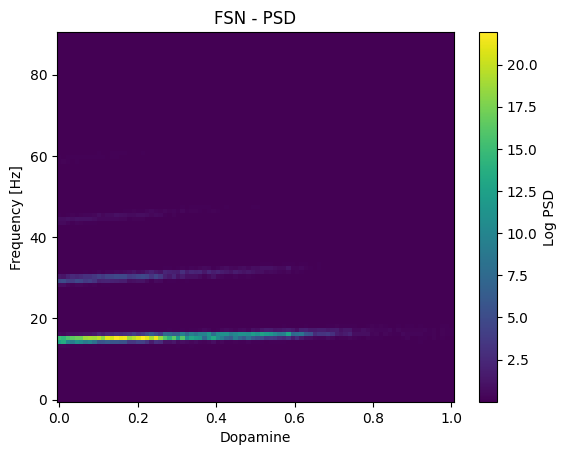

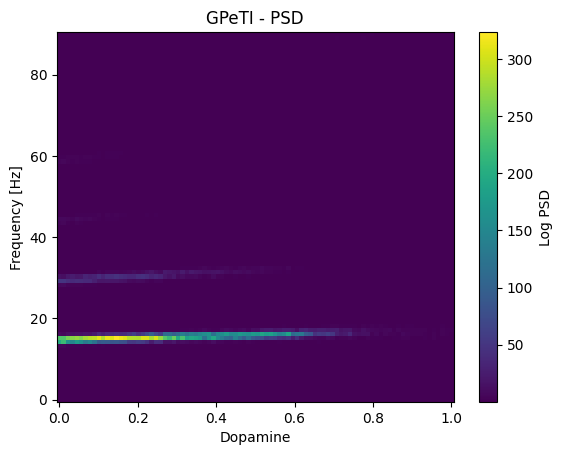

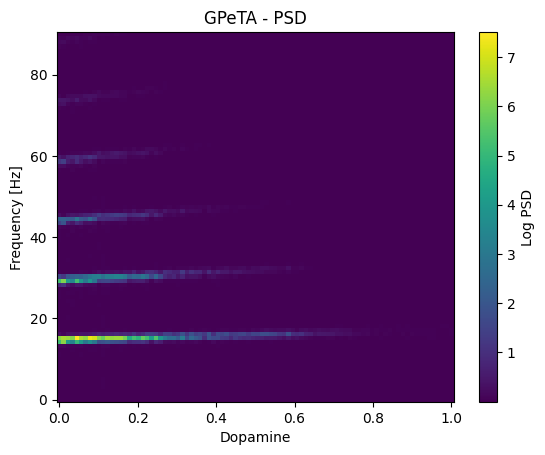

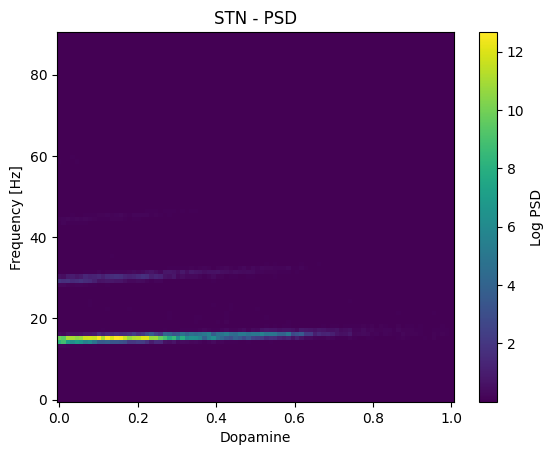

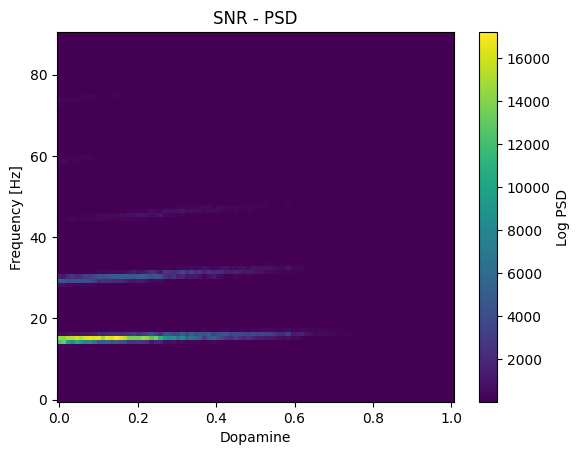

In [99]:
X, Y = np.meshgrid(dopamine_levels, np.linspace(0, 90, int(90/spectral_resolution)))
# pop = "GPeTA"
for pop in sn.populations:
    plt.pcolormesh(X, Y, spectra[pop].T)
    plt.xlabel("Dopamine")
    plt.ylabel("Frequency [Hz]")
    plt.colorbar(label = "Log PSD")
    plt.title(f"{pop} - PSD")
    plt.savefig(f"images/logPSD_{pop}.pdf")
    plt.show()

## Statistical features of the signal

In [138]:
def plot_spikecount_distrib(sn):
    for pop in sn.populations:
        fig, (ax1, ax2) = plt.subplots(2,1)
        ax1.set_title(pop)
        spikes = sn.populations[pop].get_data('spikes')
        spikes = spikes[5000:]
        ax2.plot(spikes)
        # ax2.plot(bin_spikes(spikes))
        from scipy.special import factorial
        nn = np.arange(np.min(spikes), np.max(spikes))
        histogram, bins = np.histogram(spikes, bins=nn, density=True)
        ax1.step(bins[:-1], histogram, where='mid', marker=".", label="Spike count")
        l = np.mean(spikes)
        print(l)
        ax1.step(nn, l**nn*np.exp(-l)/factorial(nn.astype(int)), marker=".", where='mid', label=r"Poisson ($\lambda$ = $\langle N \rangle$)")
        ax1.legend()
        plt.show()

In [140]:
sn.set_parameters(dopamine=1.0)
sn.run(dt=dt, time=Tshort)

Running network consisting of 14622 neurons for 15000 timesteps
--------------------------------------------------
**************************************************
Simulation took 27 s	(1.84288 ms/step)
	Gathering time avg: 0.0571962 us/step
	Inject time avg: 188.8 us/step
Population evolution stats:
	0:
		evolution:	507.788 us/step	---	84 ns/step/neuron
		spike emission:	61.4879 us/step	---	10 ns/step/neuron
	1:
		evolution:	479.807 us/step	---	79 ns/step/neuron
		spike emission:	84.4828 us/step	---	14 ns/step/neuron
	2:
		evolution:	91.9681 us/step	---	218 ns/step/neuron
		spike emission:	14.0446 us/step	---	33 ns/step/neuron
	3:
		evolution:	116.209 us/step	---	148 ns/step/neuron
		spike emission:	24.1784 us/step	---	30 ns/step/neuron
	4:
		evolution:	63.1586 us/step	---	242 ns/step/neuron
		spike emission:	6.05813 us/step	---	23 ns/step/neuron
	5:
		evolution:	73.6533 us/step	---	180 ns/step/neuron
		spike emission:	5.17332 us/step	---	12 ns/step/neuron
	6:
		evolution:	112.299 u

0.42425757424257576

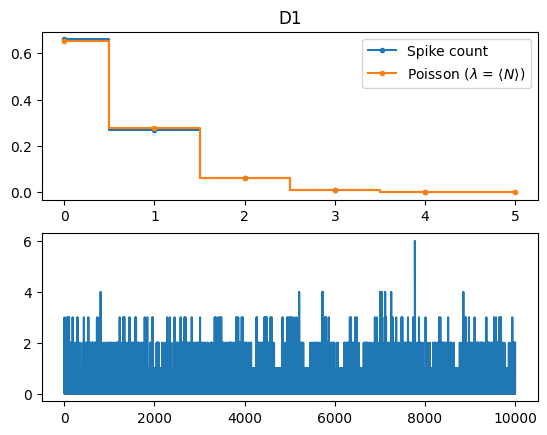

0.9667033296670333

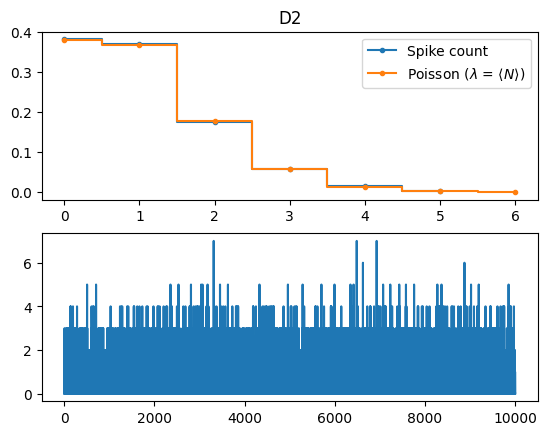

0.7015298470152985

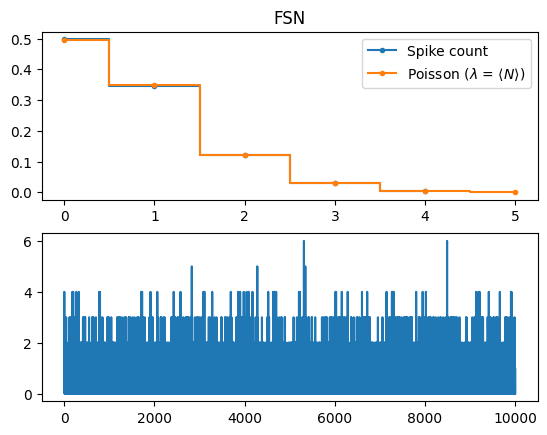

5.096090390960904

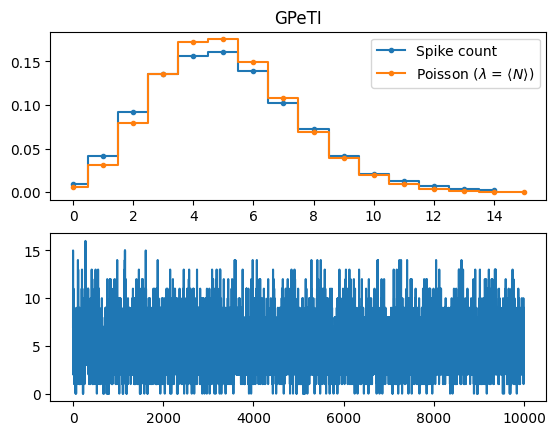

0.250974902509749

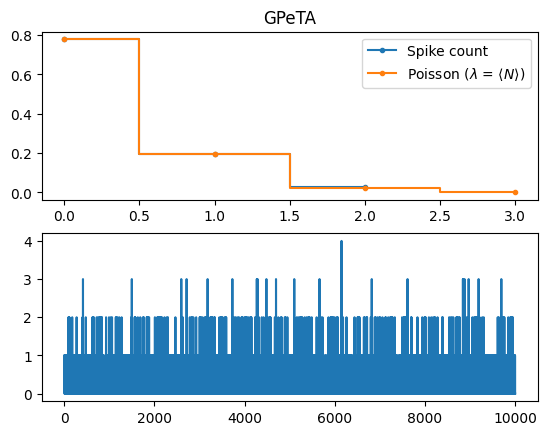

0.5445455454454554

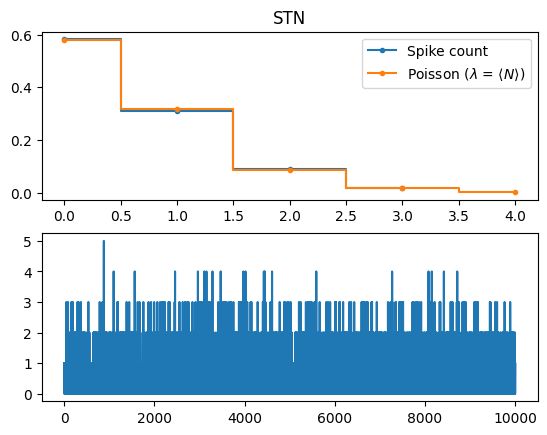

1.0186981301869813

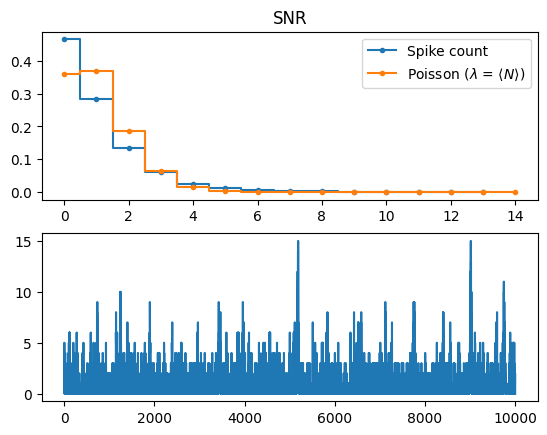

In [141]:
plot_spikecount_distrib(sn)

In [142]:
sn.set_parameters(dopamine=0.4)
sn.run(dt=dt, time=Tshort)

Running network consisting of 14622 neurons for 15000 timesteps
--------------------------------------------------
**************************************************
Simulation took 24 s	(1.66349 ms/step)
	Gathering time avg: 0.0191321 us/step
	Inject time avg: 170.769 us/step
Population evolution stats:
	0:
		evolution:	453.969 us/step	---	75 ns/step/neuron
		spike emission:	64.4178 us/step	---	10 ns/step/neuron
	1:
		evolution:	425.404 us/step	---	70 ns/step/neuron
		spike emission:	59.2918 us/step	---	9 ns/step/neuron
	2:
		evolution:	83.1975 us/step	---	198 ns/step/neuron
		spike emission:	12.8283 us/step	---	30 ns/step/neuron
	3:
		evolution:	110.351 us/step	---	141 ns/step/neuron
		spike emission:	19.2656 us/step	---	24 ns/step/neuron
	4:
		evolution:	62.6107 us/step	---	240 ns/step/neuron
		spike emission:	3.955 us/step	---	15 ns/step/neuron
	5:
		evolution:	70.6614 us/step	---	173 ns/step/neuron
		spike emission:	5.75975 us/step	---	14 ns/step/neuron
	6:
		evolution:	107.405 us

1.7903209679032097

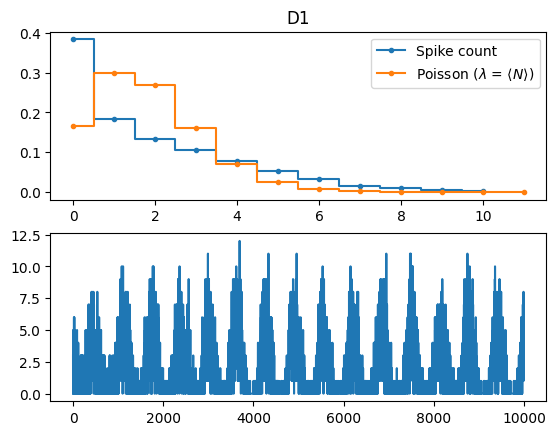

0.9617038296170383

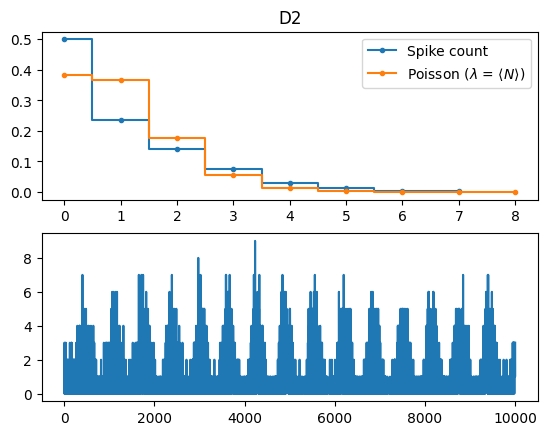

0.6118388161183882

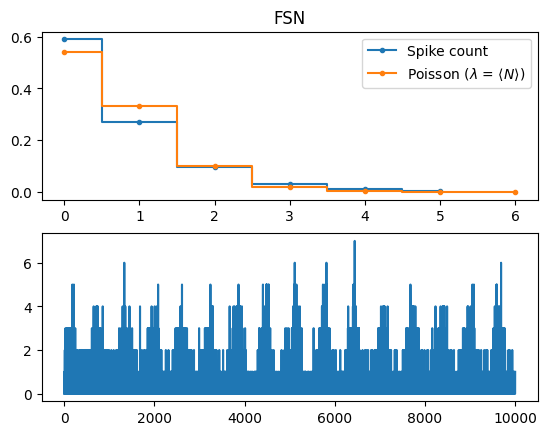

3.9148085191480853

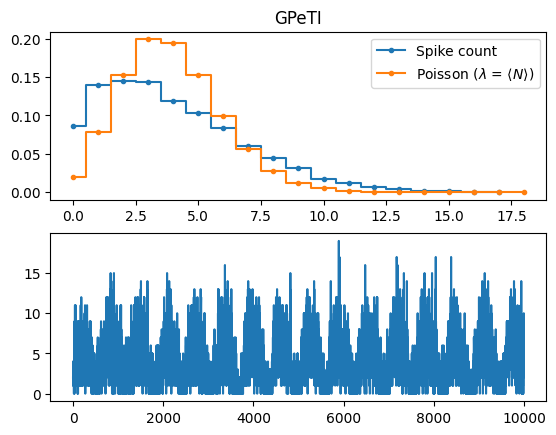

0.15528447155284472

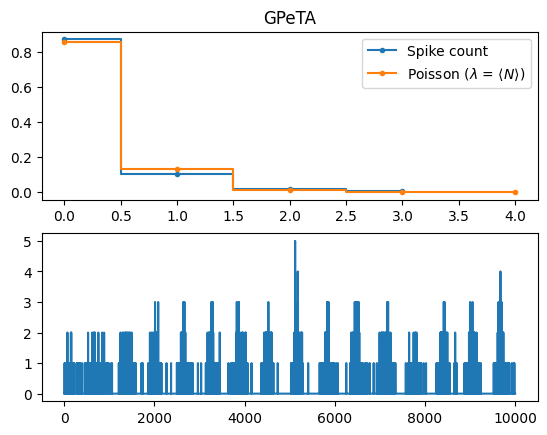

0.662933706629337

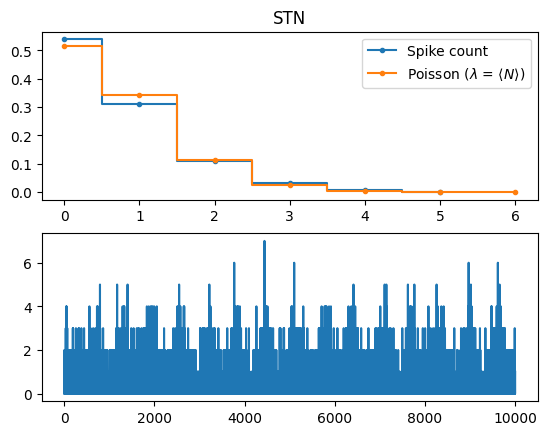

7.371762823717628

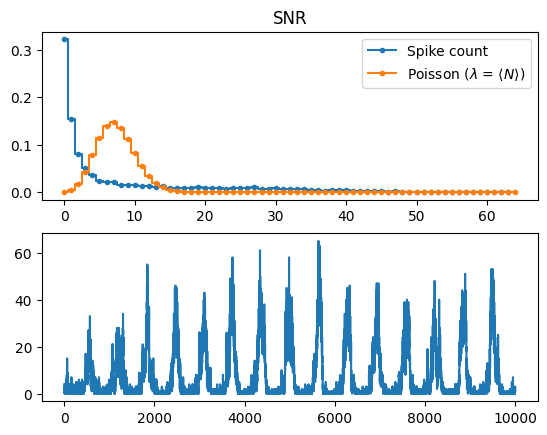

In [144]:
plot_spikecount_distrib(sn)

## Estimating rate functions

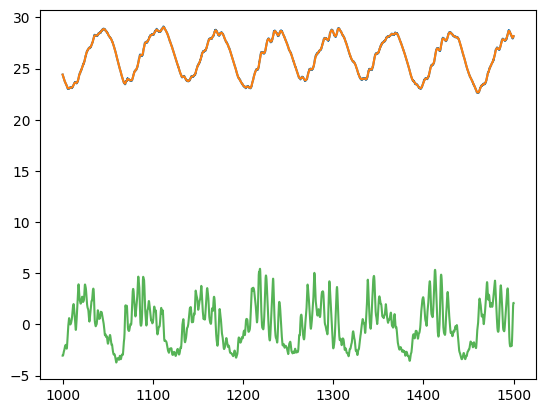

In [222]:
spikes = sn.populations['GPeTI'].get_data('spikes')
tt = np.linspace(0, Tshort, len(spikes))

mask = tt >1000

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(tt[mask].reshape(-1,1), np.cumsum(spikes)[mask])

m_fit = model.coef_[0]
b_fit = model.intercept_ 
L = np.cumsum(spikes)[mask] - m_fit*tt[mask]
plt.plot(tt[mask], 0.01*L)
for j in range(15):
    for i in range(1, len(tt[mask])-1):
        L[i] = 0.5*(L[i+1] + L[i-1])
plt.plot(tt[mask], 0.01*L)
plt.plot(tt[mask][:-1], 0.1*np.diff(L)/np.diff(tt[mask]), alpha=0.8)
# plt.ylim(0, 0.25)

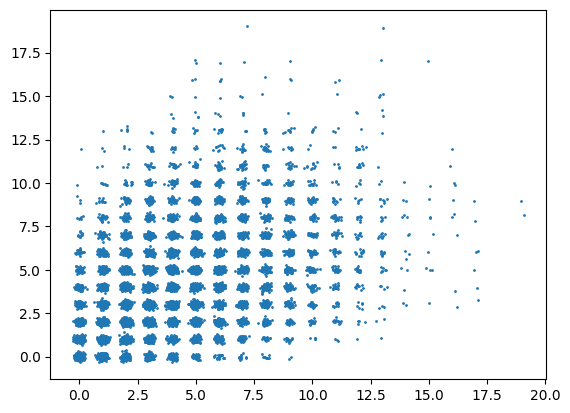

In [225]:
k = 5 
plt.scatter(spikes[:-k]+np.random.normal(0, 0.1, size=len(spikes[:-k])), spikes[k:]+np.random.normal(0, 0.1, size=len(spikes[:-k])), s=1)

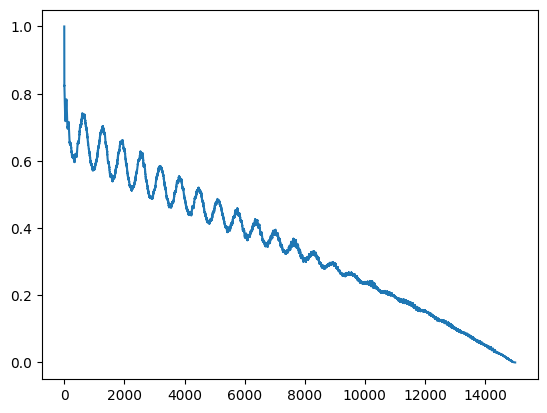

In [226]:
from scipy.signal import correlate
gg = correlate(spikes, spikes, mode='full')/np.std(spikes)**2
gg = gg[len(gg)//2:]
gg /= gg[0]
plt.plot(gg)

(0.0, 1000.0)

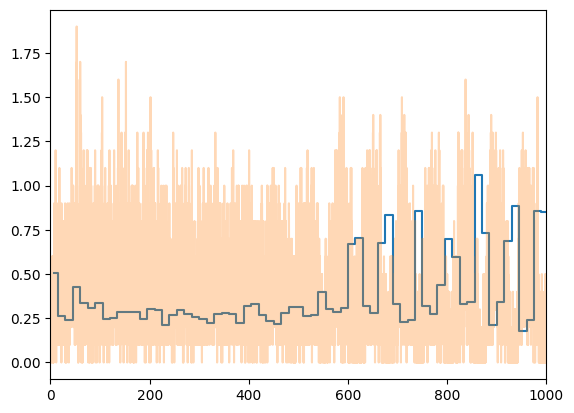

In [257]:
cvs = []
times = []
k = 100
for bunch, ttt in zip(np.split(spikes[:-(len(spikes)%k)], k),
                     np.split(tt[:-(len(spikes)%k)], k)):
    times.append(0.5*(ttt[0] + ttt[-1]))
    cvs.append(np.std(bunch)**2/np.mean(bunch)**2)
plt.step(times, cvs, where='mid')
plt.plot(tt, spikes/10, alpha=0.3)
plt.xlim(0, 1000)

## Relevance analysis

In [7]:
import yaml

with open(DOPAMINE_FILE, "r") as f:
    parameters_dict = yaml.safe_load(f)

new_parameters_dict = dict(parameters=dict(), parametric=dict())
counter = 0
for parametric in parameters_dict['parametric']['dopamine']:
    if 'population' in parametric:
        name = parametric['population'].replace(" ", "") + "_" + parametric['attribute'] 
    elif 'projection' in parametric:
        name = parametric['projection'].replace(" ", "") + "_" + parametric['attribute'] 
        
    new_parameters_dict["parameters"].update({name : {'min': 0, 'max': 1, 'shift': 0.8}})
    new_parameters_dict["parametric"][name] =[parametric]

In [8]:
from quilt.builder import ParametricSpikingNetwork
net = ParametricSpikingNetwork.from_dict(new_parameters_dict, network_file=NETWORK_FILE, neuron_file=NEURONS_FILE)
net.monitorize_spikes()

#### General sampling

In [ ]:
# import pandas as pd
# from rich.progress import track
# N = 200
# eps = 1.0
# alpha0 = 0.5
# burn_in_millis=1000

# set_verbosity(0)

# results = pd.DataFrame()
# for i in track(range(N)):
#     dopamine_array = dict()
    
#     for parameter in new_parameters_dict['parameters']:
#         dopamine_array[parameter] = alpha0 + eps/2*np.random.uniform(-1, 1)
#     net.set_parameters(**dopamine_array)

#     net.run(dt=0.1, time=5000)

#     row = dopamine_array.copy()

#     for pop in net.populations.keys():
#         fmax, fmean, norm_beta_pow, beta_pow, entropy = beta_power(net, pop)
#         row[f"{pop}_norm_beta_power"] = norm_beta_pow
#         row[f"{pop}_beta_power"] = beta_pow
#         row[f"{pop}_fmax"] = fmax
#         row[f"{pop}_entropy"] = entropy
#         row[f"{pop}_fmean"] = fmean
#     results = pd.concat([results, pd.DataFrame(row, index=[i])])

# results.to_csv("multidim_dopamine_6.csv")
# display(results)

Output()

#### Around diagonal sampling

In [96]:
import pandas as pd
from rich.progress import track
N = 10
eps = 0.05
alpha0s = np.linspace(0, 1, 30)
burn_in_millis=1000

set_verbosity(0)

results = pd.DataFrame()


for a0 in track(alpha0s):
    for i in range(N):
        dopamine_array = dict()

        for parameter in new_parameters_dict['parameters']:
            proposed_dopamine = a0 + eps/2*np.random.uniform(-1, 1)
            while proposed_dopamine < 0 or proposed_dopamine > 1:
                proposed_dopamine = a0 + eps/2*np.random.uniform(-1, 1)
            dopamine_array[parameter] = proposed_dopamine
        net.set_parameters(**dopamine_array)

        net.run(dt=0.1, time=5000)

        row = dopamine_array.copy()

        for pop in net.populations.keys():
            pop_result = beta_power(net, pop)
            for key in pop_result:
                row[f"{pop}_{key}"] = pop_result[key]
            row[f"{pop}_mean_fr"] = firing_rate(net, pop)
        results = pd.concat([results, pd.DataFrame(row, index=[len(results)])])

results.to_csv("multidim_dopamine_around_diagonal_5.csv")
display(results)

Output()

,FSN_E_l,GPeTI_E_l,GPeTA_E_l,D1_V_peak,D1_ada_b,SNR_E_l,FSN->FSN_weight,GPeTA->FSN_weight,GPeTI->FSN_weight,GPeTA->GPeTA_weight,...,SNR_fmax,SNR_fmean,SNR_norm_beta_power,SNR_norm_low_gamma_power,SNR_norm_high_gamma_power,SNR_beta_power,SNR_low_gamma_power,SNR_high_gamma_power,SNR_entropy,SNR_mean_fr
0,0.009578,0.004352,0.010279,0.004154,0.010854,0.017980,0.013067,0.023786,0.022583,0.012100,...,14.5,16.596783,0.907230,0.010510,0.034201,35671.269334,413.257014,1344.729082,1.796978,187.132891
1,0.011902,0.010877,0.001412,0.014118,0.016739,0.015726,0.019219,0.015598,0.014366,0.005879,...,14.5,16.442921,0.909174,0.010104,0.036302,36560.479231,406.322780,1459.805677,1.767331,191.840053
2,0.018875,0.021241,0.002225,0.022815,0.011486,0.017177,0.021024,0.019460,0.015161,0.001854,...,14.5,16.618315,0.883116,0.015344,0.030422,33648.983173,584.643050,1159.143252,1.851762,182.002122
3,0.006023,0.018647,0.024997,0.014899,0.015978,0.007830,0.008959,0.014476,0.010588,0.012864,...,14.5,16.337187,0.877384,0.011773,0.036372,34339.256677,460.774678,1423.524472,1.783516,187.152520
4,0.014710,0.008844,0.015009,0.023247,0.023955,0.013197,0.014954,0.000903,0.013542,0.004161,...,14.5,16.479159,0.908312,0.010248,0.034746,36280.452225,409.347454,1387.868911,1.762864,189.297347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.989745,0.986869,0.976089,0.991096,0.985284,0.979017,0.987837,0.994512,0.975325,0.983561,...,16.0,18.361504,0.168758,0.104748,0.189475,14.948043,9.278281,16.783136,5.983623,13.962334
296,0.987826,0.982346,0.985157,0.990745,0.979432,0.990103,0.993365,0.993525,0.997338,0.991196,...,17.0,18.955108,0.153444,0.077388,0.235644,13.155172,6.634725,20.202408,5.971933,13.168435
297,0.978348,0.985309,0.987154,0.996252,0.980581,0.989058,0.999729,0.978644,0.990850,0.983341,...,16.0,18.653220,0.121794,0.090977,0.214842,11.757271,8.782371,20.739595,6.038347,14.885676
298,0.999905,0.984060,0.997573,0.995216,0.978763,0.979887,0.981877,0.987038,0.981544,0.994866,...,96.5,18.808550,0.129368,0.097865,0.205195,10.558474,7.987311,16.747204,6.029460,13.899204


### On-diagonal sampling

In [14]:
import pandas as pd
from rich.progress import track

alpha0s = np.linspace(0, 1, 15)
N = 3
burn_in_millis=1000

set_verbosity(0)
results = pd.DataFrame()

for a0 in track(alpha0s):
    for i in range(N):
        dopamine_array = dict()
    
        for parameter in new_parameters_dict['parameters']:
            dopamine_array[parameter] = a0
        net.set_parameters(**dopamine_array)
    
        net.run(dt=0.1, time=5000)
    
        row = dopamine_array.copy()
    
        for pop in net.populations.keys():
            pop_result = beta_power(net, pop)
            for key in pop_result:
                row[f"{pop}_{key}"] = pop_result[key]
            row[f"{pop}_mean_fr"] = firing_rate(net, pop)
        results = pd.concat([results, pd.DataFrame(row, index=[len(results)])])

results.to_csv("multidim_dopamine_diagonal_3_trials.csv")
display(results)

Output()

,FSN_E_l,GPeTI_E_l,GPeTA_E_l,D1_V_peak,D1_ada_b,SNR_E_l,FSN->FSN_weight,GPeTA->FSN_weight,GPeTI->FSN_weight,GPeTA->GPeTA_weight,...,SNR_fmax,SNR_fmean,SNR_norm_beta_power,SNR_norm_low_gamma_power,SNR_norm_high_gamma_power,SNR_beta_power,SNR_low_gamma_power,SNR_high_gamma_power,SNR_entropy,SNR_mean_fr
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.5,16.363816,0.857084,0.014544,0.035560,33273.152142,564.633809,1380.490754,1.854705,184.941910
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.5,16.652001,0.945965,0.008419,0.038226,37987.437866,338.075656,1535.043898,1.794427,192.874801
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.5,16.549224,0.930887,0.008786,0.036183,37136.999285,350.492037,1443.495472,1.759326,190.383554
3,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,...,14.5,16.331318,0.806684,0.026312,0.027928,29278.476382,954.996570,1013.626174,1.861444,178.500000
4,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,...,14.5,16.785105,0.888614,0.017709,0.030866,33855.634095,674.695187,1175.989757,1.861708,179.950928
5,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,...,15.0,16.231140,0.781475,0.037332,0.025629,26953.579433,1287.609638,883.973170,1.854260,174.489920
6,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,...,15.0,15.650535,0.724005,0.102708,0.024684,20625.829811,2925.986755,703.222653,1.896836,164.342706
7,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,...,15.0,15.492649,0.728716,0.118473,0.020670,20442.844355,3323.552113,579.872148,1.840148,164.063660
8,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,...,15.0,15.719947,0.707366,0.124590,0.020057,19379.114386,3413.282478,549.484823,1.964691,155.888329
9,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,...,15.0,15.376067,0.654581,0.256984,0.020422,18609.717861,7306.045561,580.602293,2.035852,153.236074


### Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt 
import optuna 
import seaborn as sns
import pandas as pd

In [96]:
populations = ["D1", "D2", "FSN", "STN", "GPeTI", "GPeTA"]

# data_1 = pd.read_csv("multidim_dopamine_around_diagonal_3.csv")

# for pop in populations:
#     data_1[f"{pop}_fmean"] /= 2

data_2 = pd.read_csv("multidim_dopamine_around_diagonal_4.csv")
data_1 = pd.read_csv("multidim_dopamine_around_diagonal_5.csv")

# data_3 = pd.read_csv("multidim_dopamine_diagonal_4_trials.csv")
# data_4 = pd.read_csv("multidim_dopamine_diagonal_3_trials.csv")

data = pd.concat([data_1, data_2])


# data = data_4.copy()

try:
    data = data.drop(columns = ["Unnamed: 0"])
    # data = data.drop(columns = ["level_0"])
except KeyError:
    pass

data = data.reset_index(drop=True)

features = []
observables = []

for col in data.columns:
    if "power" in col or "entropy" in col or "fmax" in col or "fmean" in col or "mean_fr" in col:
        observables.append(col)
    else:
        features.append(col)

# data = data.loc[np.mean(data[features], axis=1) <0.8]


X = data[features].to_numpy()
analysis_feature = "STN_beta_power"
y = data[analysis_feature].to_numpy()

data['alpha'] = np.mean(X, axis=1)

In [146]:
from umap import UMAP

red = UMAP(n_neighbors=100)
embedding = red.fit_transform(X)

2024-05-19 11:29:52.891526: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 11:29:52.891884: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 11:29:52.894441: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 11:29:52.920473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 11:29:53.594958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

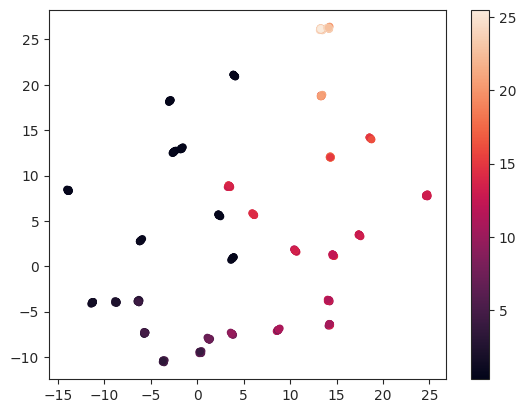

In [147]:
plt.scatter(*embedding.T, c=data.STN_beta_power, s=20)
plt.colorbar()

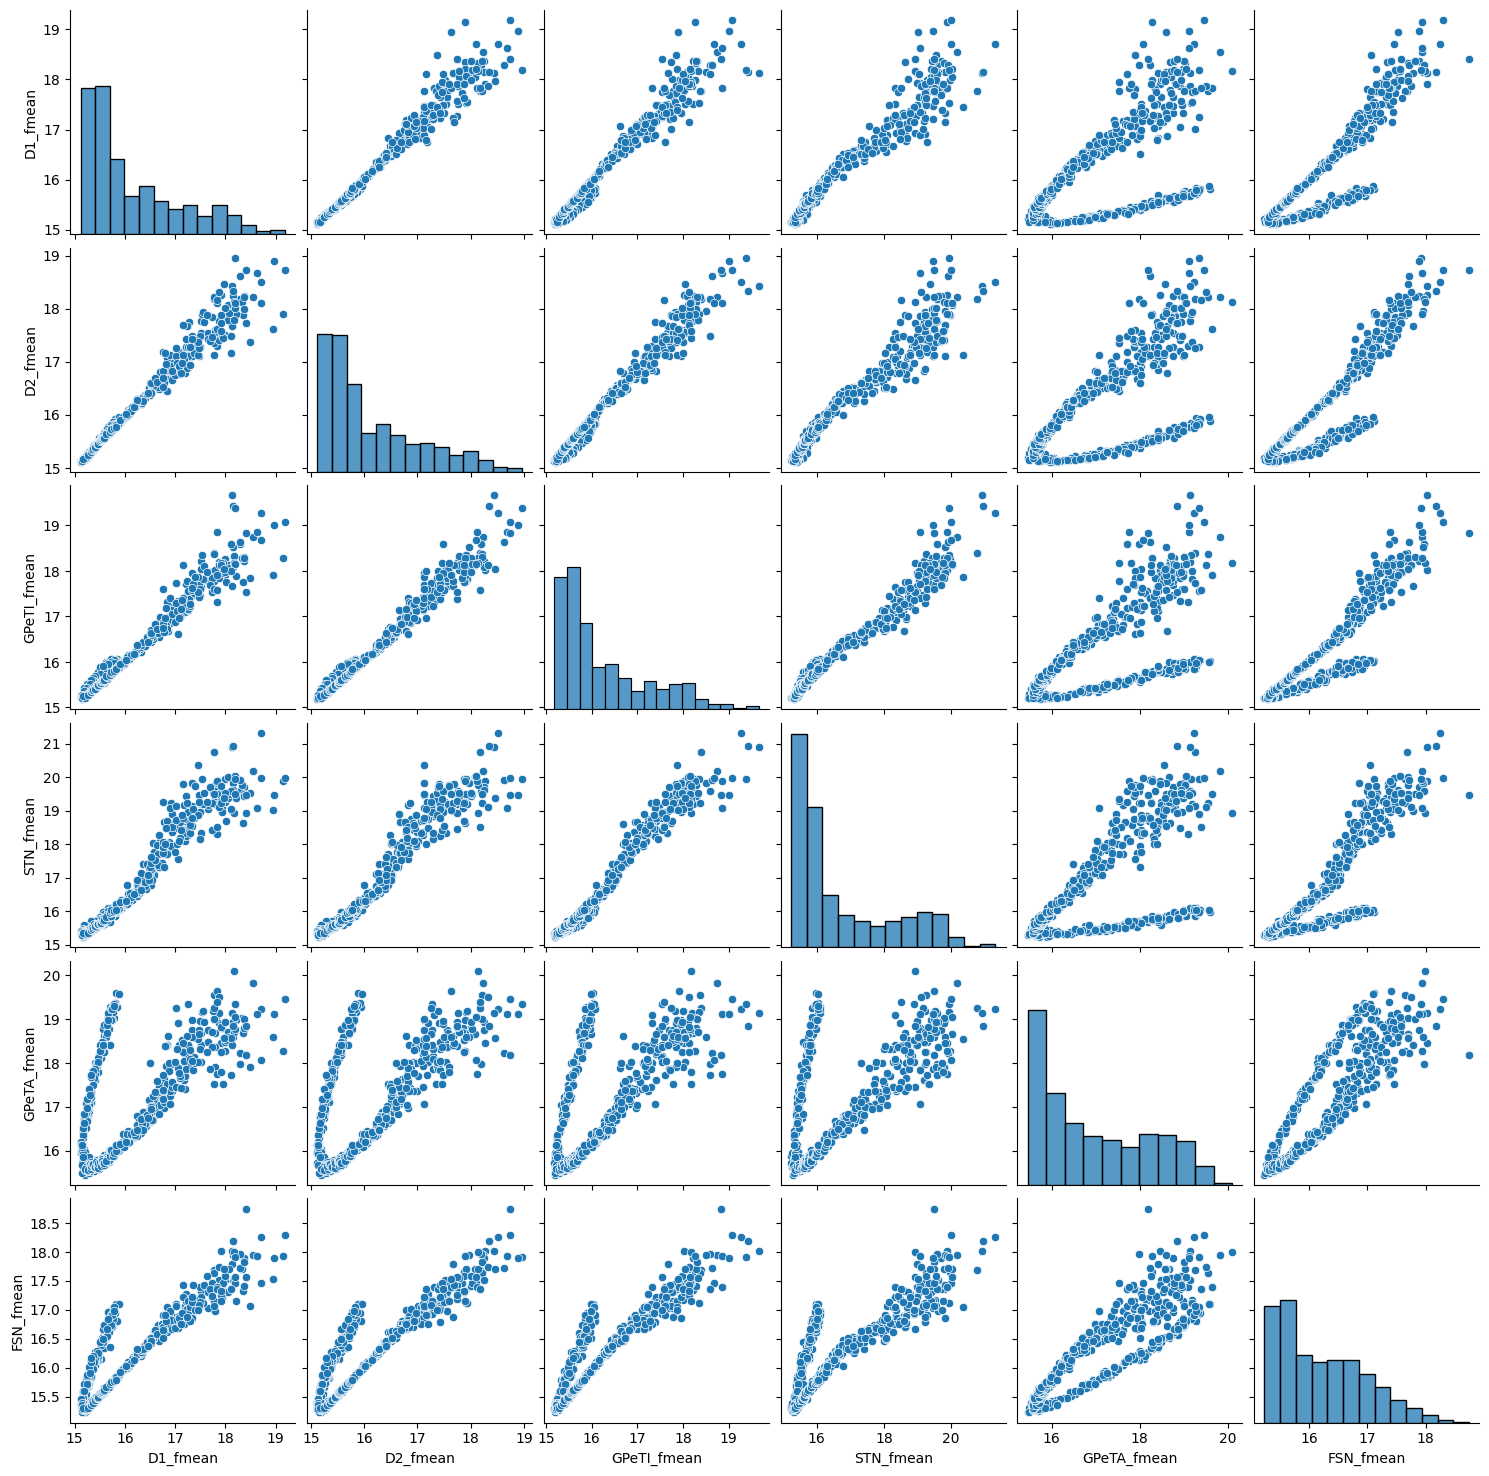

In [97]:
fmean_data = data[[o for o in observables if "fmean" in o]]
order = [f"{pop}_fmean" for pop in ["D1", "D2", "GPeTI", "STN", "GPeTA", "FSN"]]
fmean_data=fmean_data.reindex(columns=order)
sns.pairplot(fmean_data)

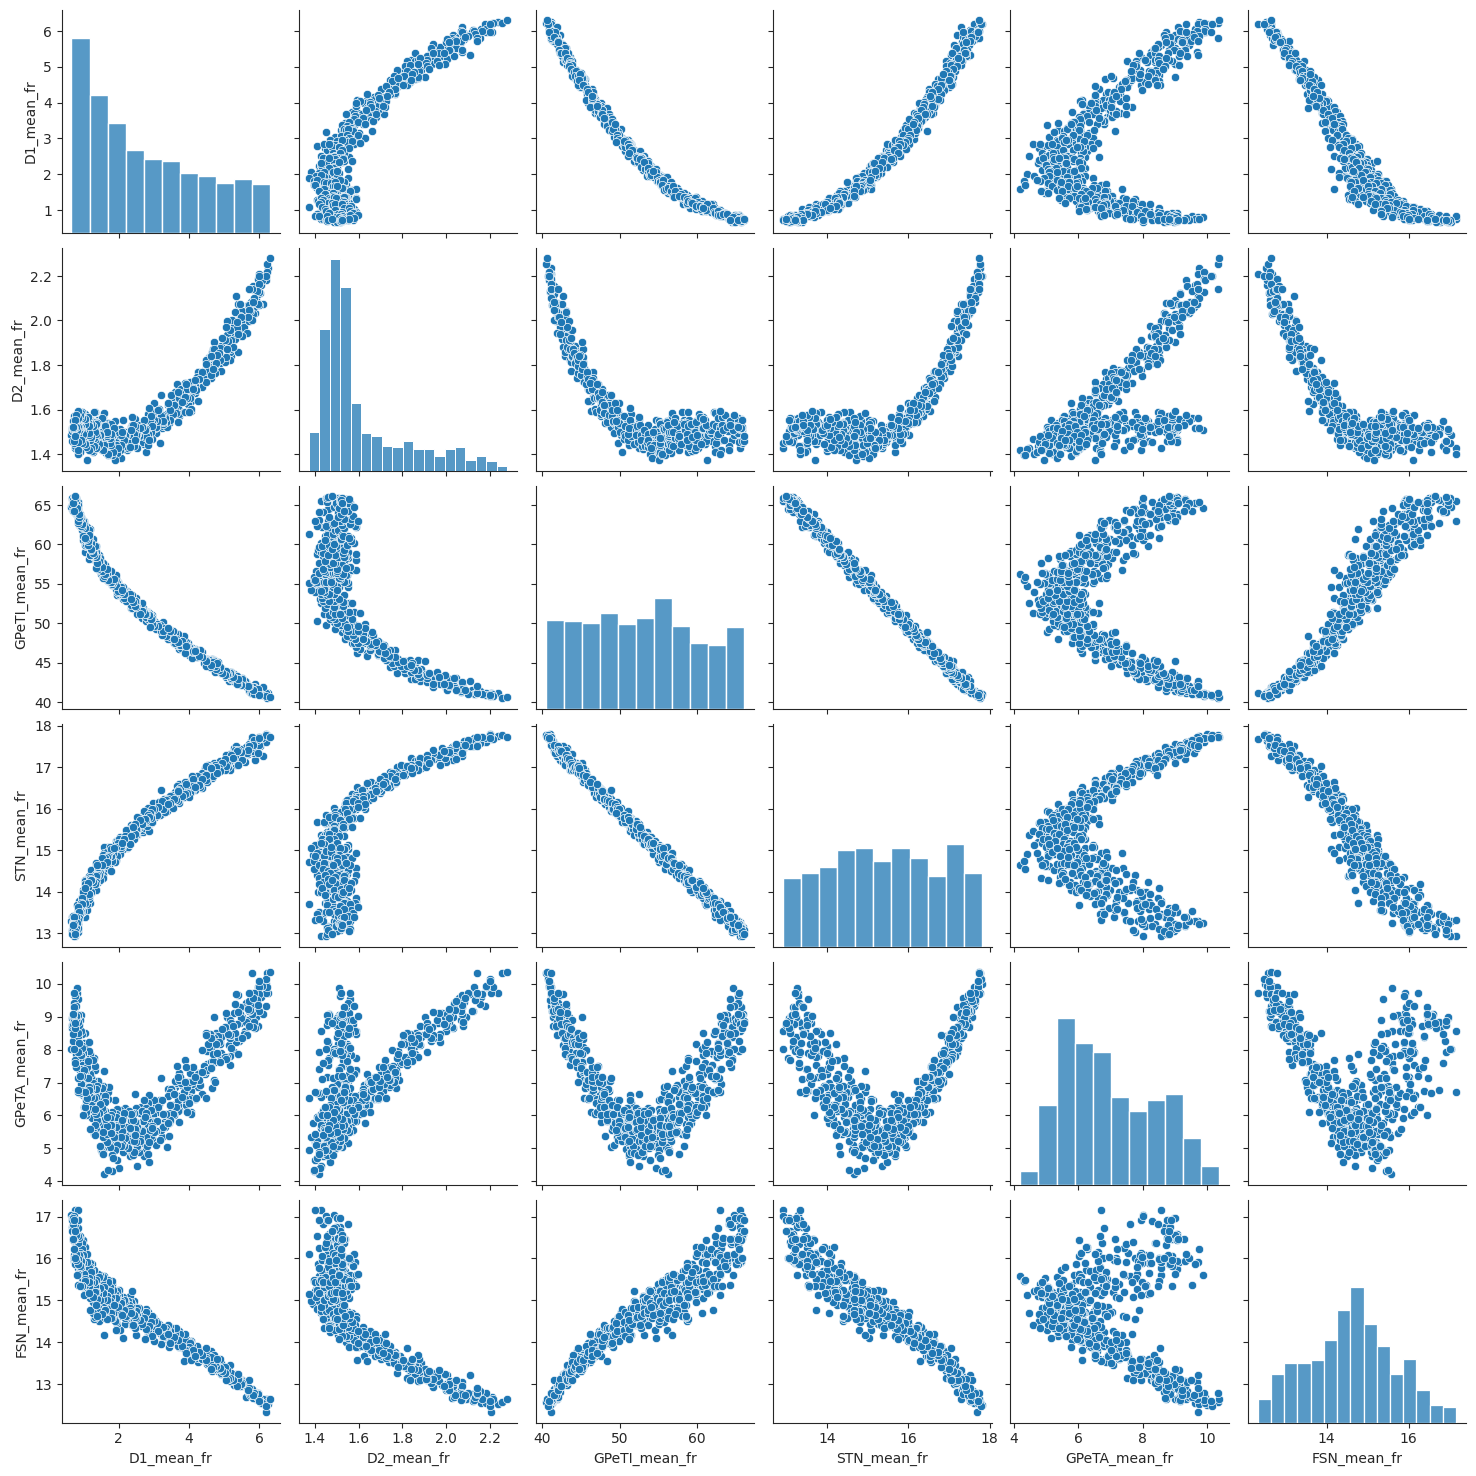

In [149]:
mean_fr_data = data[[o for o in observables if "mean_fr" in o]]
order = [f"{pop}_mean_fr" for pop in ["D1", "D2", "GPeTI", "STN", "GPeTA", "FSN"]]
mean_fr_data=mean_fr_data.reindex(columns=order)
sns.pairplot(mean_fr_data)

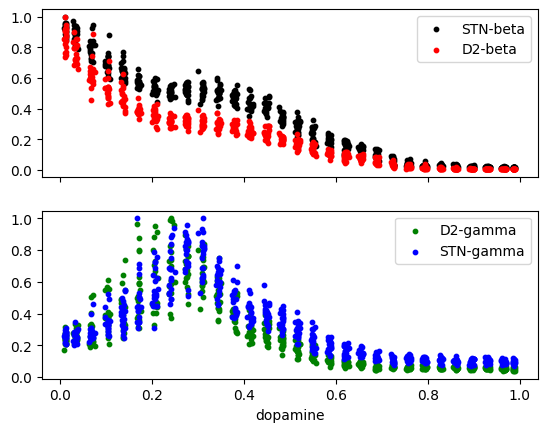

In [98]:
plt.close()
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
# plt.scatter(data.alpha, data.STN_beta_power, c=data.STN_fmean, s=10)
# plt.scatter(data.alpha, data.STN_low_gamma_power, c=data.STN_fmean, s=10)

ax1.scatter(data.alpha, data.STN_beta_power/np.max(data.STN_beta_power), color="k", s=10, label="STN-beta")
ax1.scatter(data.alpha, data.D2_beta_power/np.max(data.D2_beta_power), color="r", s=10, label="D2-beta")
ax2.scatter(data.alpha, data.D2_low_gamma_power/np.max(data.D2_low_gamma_power), color="g", s=10, label="D2-gamma")
ax2.scatter(data.alpha, data.STN_low_gamma_power/np.max(data.STN_low_gamma_power), color="b", s=10, label="STN-gamma")

plt.xlabel("dopamine")
ax1.legend()
ax2.legend()

/tmp/ipykernel_995746/4125441711.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


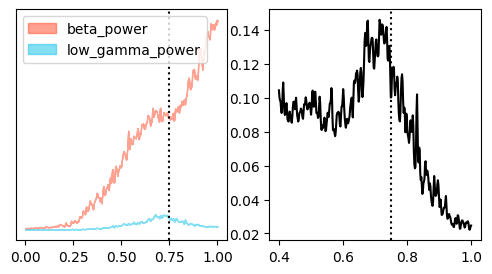

In [99]:
from scipy.ndimage.filters import gaussian_filter1d

pop = "STN"
fig, (ax, ax2) = plt.subplots(1,2, figsize=(6,3))
Npoints = len(np.unique(data.alpha))
mmean, vvariance = np.zeros((2, Npoints)), np.zeros((2, Npoints))

feats = ["beta_power", "low_gamma_power"]
colors = np.array(sns.color_palette("rainbow", 10))[[9,2], :]
# print(colors)
for j in range(2):
    feat = feats[j]
    color= colors[j]
    for i in range(Npoints):
        alphaval = np.unique(data.alpha)[i]
        subdf = data[data.alpha==alphaval]
        mmean[j,i] = np.mean(subdf[f"{pop}_{feat}"])
        vvariance[j,i] = np.std(subdf[f"{pop}_{feat}"])
        
    alphanew = np.linspace(0,1, len(np.unique(data.alpha)))
    smooth_m = gaussian_filter1d(np.flip(mmean[j]), sigma=1.3)
    smooth_var = gaussian_filter1d(np.flip(vvariance[j]), sigma=1.3)
    # ax.plot(alphanew, smooth, color="k")
    # ax.plot(alphanew, np.flip(mmean[j]))
    # 
    ax.fill_between(alphanew, (smooth_m - smooth_var), (smooth_m + smooth_var), color=color, alpha=0.5, label=feat)
    # ax.scatter(1- data.alpha, data[f"{pop}_{feat}"], s=5, color="k")

ax.legend(loc='upper left')
ax.set_yticks([])

# ax.set_yscale('log')
mask = alphanew > 0.4
ax2.plot(alphanew[mask], gaussian_filter1d(np.flip(mmean[1]/mmean[0])[mask], sigma=1), color="k")
ax.axvline(0.75,ls=":", color="k")
ax2.axvline(0.75,ls=":", color="k")
# fig.savefig("images/depletion_vs_beta.pdf")

In [72]:
data

,FSN_E_l,GPeTI_E_l,GPeTA_E_l,D1_V_peak,D1_ada_b,SNR_E_l,FSN->FSN_weight,GPeTA->FSN_weight,GPeTI->FSN_weight,GPeTA->GPeTA_weight,...,SNR_fmean,SNR_norm_beta_power,SNR_norm_low_gamma_power,SNR_norm_high_gamma_power,SNR_beta_power,SNR_low_gamma_power,SNR_high_gamma_power,SNR_entropy,SNR_mean_fr,alpha
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.495493,0.929623,0.007096,0.038933,37582.221961,286.870635,1573.942540,1.740888,191.974005,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.423771,0.905025,0.011126,0.035113,35639.076993,438.123992,1382.719201,1.810590,190.432891,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.779345,0.950784,0.011492,0.032988,37053.290834,447.853565,1285.596416,1.855872,187.508488,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.525083,0.940620,0.007398,0.034413,37703.746061,296.524907,1379.410942,1.710284,191.487533,0.000000
4,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,...,16.391860,0.875837,0.011213,0.033003,33882.039367,433.777532,1276.716176,1.779240,187.909549,0.034483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,...,18.414824,0.163980,0.075115,0.221268,21.507207,9.851890,29.020885,5.959504,16.336074,0.928571
161,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,...,17.664399,0.211270,0.085242,0.242904,32.674614,13.183401,37.567050,5.812442,17.798408,0.928571
162,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,18.602588,0.141797,0.080756,0.239450,10.138299,5.773915,17.120346,6.021509,13.496286,1.000000
163,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,18.187209,0.155031,0.058662,0.242314,10.772940,4.076354,16.838113,6.021307,13.323342,1.000000


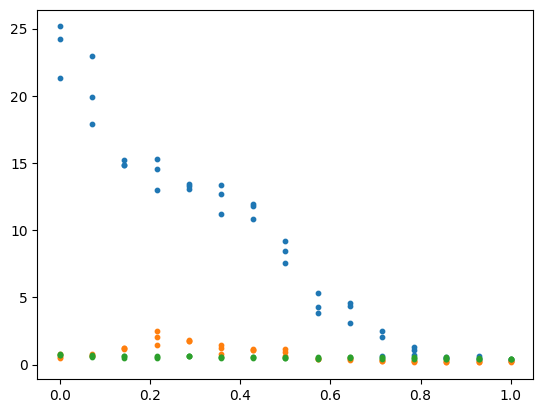

In [23]:
pop = "STN"
plt.scatter(data.alpha, data[f"{pop}_beta_power"],s=10)
plt.scatter(data.alpha, data[f"{pop}_low_gamma_power"], s=10)
plt.scatter(data.alpha, data[f"{pop}_high_gamma_power"], s=10)

In [24]:
from matplotlib.colors import ListedColormap

pop1 = "STN"
pop2 = "GPeTI"

cmap = ListedColormap(sns.color_palette("rainbow_r", 4).as_hex())
for i in range(len(populations)):
    for j in range(i):
        pop1 = populations[i]
        pop2 = populations[j]
        comparison = data[features + [f"{pop1}_fmean", f"{pop2}_fmean"]]
        comparison.loc[:, "difference"] =  comparison.loc[:, f"{pop1}_fmean"].to_numpy() - comparison[f"{pop2}_fmean"].to_numpy()
        comparison["alpha"] = np.mean(comparison[features], axis=1)
        # plt.scatter(comparison.alpha, np.abs(comparison.difference))
        
        size = data[f"{pop1}_beta_power"] + data[f"{pop2}_beta_power"]
        size = 50*MinMaxScaler().fit_transform(size.to_numpy().reshape(-1,1)) + 5
        
        fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
        
        plt.scatter(comparison[f"{pop1}_fmean"], comparison[f"{pop2}_fmean"], 
                    c= comparison.alpha, 
                    s=size, 
                    cmap=cmap
        )
        cbar = plt.colorbar(shrink=0.73)
        cbar.set_label("Average dopamine")
        plt.xlabel(f"{pop1} mean frequency")
        plt.ylabel(f"{pop2} mean frequency")
        
        allvals = np.concatenate((comparison[f"{pop1}_fmean"],comparison[f"{pop2}_fmean"]))
        
        plt.plot([np.min(allvals), np.max(allvals)], 
                 [np.min(allvals), np.max(allvals)],
                color="k", ls=":")
        ax.set_aspect("equal")
        
        # Creiamo una legenda personalizzata
        plt.scatter([], [], color='gray', s=20, label='High beta power')  # Pallino grigio grande
        plt.scatter([], [], color='gray', s=5, label='Low beta power')    # Pallino grigio piccolo

        # plt.scatter(data[f"{pop1}_fmax"], data[f"{pop2}_fmax"], s=2, color="k")
        # Aggiungiamo la legenda al plot
        plt.legend()
        plt.savefig(f"images/loops_syncronization_{pop1}{pop2}.pdf", bbox_inches="tight")

/tmp/ipykernel_1751745/402417751.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison.loc[:, "difference"] =  comparison.loc[:, f"{pop1}_fmean"].to_numpy() - comparison[f"{pop2}_fmean"].to_numpy()
/tmp/ipykernel_1751745/402417751.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison["alpha"] = np.mean(comparison[features], axis=1)


NameError: name 'MinMaxScaler' is not defined

In [25]:
from matplotlib.colors import ListedColormap

pop1 = "STN"
pop2 = "GPeTI"

cmap = ListedColormap(sns.color_palette("rainbow_r", 4).as_hex())
for i in range(len(populations)):
    for j in range(i):
        pop1 = populations[i]
        pop2 = populations[j]
        comparison = data[features + [f"{pop1}_mean_fr", f"{pop2}_mean_fr"]]
        comparison.loc[:, "difference"] =  comparison.loc[:, f"{pop1}_mean_fr"].to_numpy() - comparison[f"{pop2}_mean_fr"].to_numpy()
        comparison["alpha"] = np.mean(comparison[features], axis=1)
        # plt.scatter(comparison.alpha, np.abs(comparison.difference))
        
        size = data[f"{pop1}_beta_power"] + data[f"{pop2}_beta_power"]
        size = 50*MinMaxScaler().fit_transform(size.to_numpy().reshape(-1,1)) + 5
        
        fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
        
        plt.scatter(comparison[f"{pop1}_mean_fr"], comparison[f"{pop2}_mean_fr"], 
                    c= comparison.alpha, 
                    s=size, 
                    cmap=cmap
        )
        cbar = plt.colorbar(shrink=0.73)

        try:
            plt.scatter([reasonable_firing[pop1]], [reasonable_firing[pop2]], s=100, marker="X", color="k")
        except KeyError:
            pass
        cbar.set_label("Average dopamine")
        plt.xlabel(f"{pop1} mean firing rate")
        plt.ylabel(f"{pop2} mean firing rate")
        
        # allvals = np.concatenate((comparison[f"{pop1}_mean_fr"],comparison[f"{pop2}_mean_fr"]))
        
        # plt.plot([np.min(allvals), np.max(allvals)], 
        #          [np.min(allvals), np.max(allvals)],
        #         color="k", ls=":")
        # ax.set_aspect("equal")
        
        # Creiamo una legenda personalizzata
        plt.scatter([], [], color='gray', s=20, label='High beta power')  # Pallino grigio grande
        plt.scatter([], [], color='gray', s=5, label='Low beta power')    # Pallino grigio piccolo

        # plt.scatter(data[f"{pop1}_fmax"], data[f"{pop2}_fmax"], s=2, color="k")
        # Aggiungiamo la legenda al plot
        plt.legend()
        plt.savefig(f"images/firing_rates_{pop1}{pop2}.pdf", bbox_inches="tight")

/tmp/ipykernel_1751745/2525767357.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison.loc[:, "difference"] =  comparison.loc[:, f"{pop1}_mean_fr"].to_numpy() - comparison[f"{pop2}_mean_fr"].to_numpy()
/tmp/ipykernel_1751745/2525767357.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison["alpha"] = np.mean(comparison[features], axis=1)


NameError: name 'MinMaxScaler' is not defined

In [ ]:
fmean_data = data[[o for o in observables if "fmean" in o]]
order = [f"{pop}_fmean" for pop in ["D1", "D2", "GPeTI", "STN", "GPeTA", "FSN"]]
fmean_data=fmean_data.reindex(columns=order)

fmean_difference = pd.DataFrame(columns=["D1", "D2", "GPeTI", "FSN", "STN", "GPeTA"])
for pop1 in fmean_difference.columns:
    row = dict()
    for pop2 in fmean_difference.columns:
        row[pop2] = np.mean(np.abs(fmean_data[f"{pop1}_fmean"] - fmean_data[f"{pop2}_fmean"]))
    row = pd.DataFrame(row, index=[pop1])
    fmean_difference = pd.concat([fmean_difference, row])
fmean_difference

# fmean_difference.index=["D1", "D2", "GPeTI", "STN", "GPeTA", "FSN"]
# fmean_data
# plt.gca().set_aspect("equal")
sns.heatmap(fmean_difference)

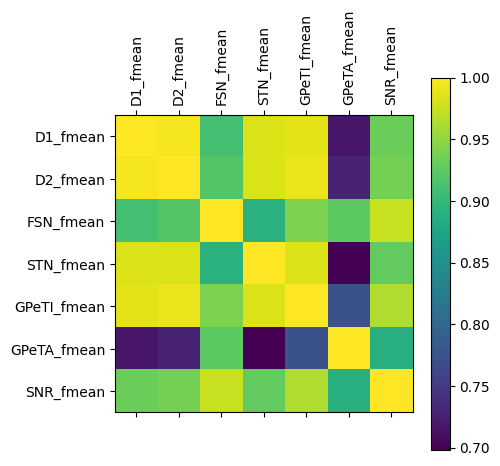

In [26]:
from scipy.stats import  spearmanr

populations = ["D1", "D2", "FSN", "STN", "GPeTI", "GPeTA", "SNR"]
beta_power_observables = [f"{pop}_fmean" for pop in populations]

M = len(beta_power_observables)
spearman_beta = np.zeros((M, M))

for i in range(M):
    for j in range(M):
        spearman_beta[i,j] = spearmanr(data[beta_power_observables[i]], data[beta_power_observables[j]])[0]

plt.matshow(spearman_beta)
plt.yticks(range(M), labels=beta_power_observables);
plt.xticks(range(M), labels=beta_power_observables, rotation=90);
plt.colorbar()
# sns.heatmap|(spearman_beta, annot=True)


### Neural networks

In [28]:
from sklearn.model_selection import train_test_split


train_ids, val_ids = train_test_split(np.arange(len(X)),  test_size=0.1)

pop = "STN"
analysis_feature1 = "beta_power"
analysis_feature2 = "low_gamma_power"
analysis_feature3 = "high_gamma_power"

y = data[f"{pop}_{analysis_feature2}"].to_numpy()

In [30]:
from sklearn.metrics import mean_squared_error
import optuna

def create_model(params):

    model = Sequential()
    model.add(Dense(X.shape[1], activation='linear'))

    for i in range(params["n_hidden"]):
        model.add(Dense(params["n_units"], activation='softplus'))

    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error',
                  optimizer="adam")
    return model


# objective function to be minimized
def objective_fun(trial):
    
    params = dict(n_units=trial.suggest_int("n_units", 64, 256),
                 n_hidden=trial.suggest_int("n_hidden", 8, 16),
#                  learning_rate=trial.suggest_float("learning_rate", 1e-5, 1e-1)
                 )
    
    model = create_model(params)
    model.fit(X[train_ids], y[train_ids], 
              epochs=trial.suggest_int("epochs", 150, 200), 
              batch_size=10, 
              validation_data=(X[val_ids], y[val_ids]), 
              verbose=False)
    y_pred = model.predict(X[val_ids], verbose=False)

    error = mean_squared_error(y_pred, y[val_ids])
    return error


# study = optuna.create_study(direction="minimize")
# study.optimize(objective_fun, n_trials=100, n_jobs=-1)

In [31]:
params = dict(n_hidden=10, n_units=128)

pop = "GPeTI"
# params = study.best_params
nn1 = create_model(params)
nn1.fit(X, data[f"{pop}_{analysis_feature1}"], epochs=300, batch_size=100, verbose=False)

nn2 = create_model(params)
nn2.fit(X, data[f"{pop}_{analysis_feature2}"], epochs=300, batch_size=100, verbose=False)

nn3 = create_model(params)
nn3.fit(X, data[f"{pop}_{analysis_feature3}"], epochs=300, batch_size=100, verbose=False)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f94cc40c310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


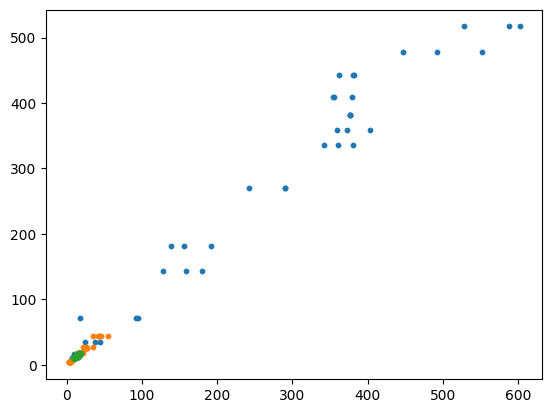

In [32]:
plt.scatter(data[f"{pop}_{analysis_feature1}"], nn1.predict(X), s=10)
plt.scatter(data[f"{pop}_{analysis_feature2}"], nn2.predict(X), s=10)
plt.scatter(data[f"{pop}_{analysis_feature3}"], nn3.predict(X), s=10)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Text(0, 0.5, 'GPeTI')

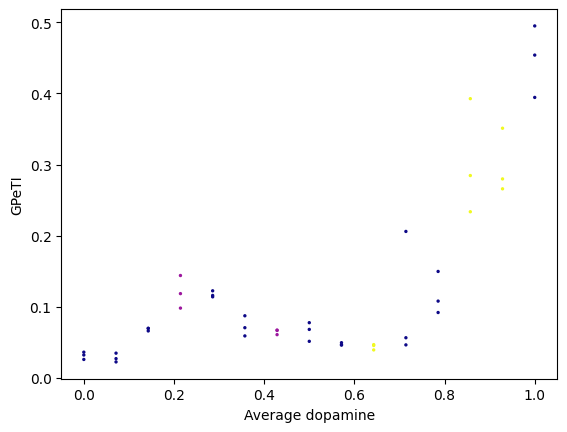

In [36]:
XX = np.repeat(np.linspace(0.0, 1.0, 100), X.shape[1]).reshape(-1,X.shape[1] )

plt.plot(XX[:,0], nn1.predict(XX), color="k")
plt.plot(XX[:,0], nn2.predict(XX), color="k")
plt.plot(XX[:,0], nn3.predict(XX), color="k")
plt.close()

importance = np.exp(-np.std(X, axis=1))
from sklearn.preprocessing import MinMaxScaler
importance = MinMaxScaler().fit_transform(importance.reshape(-1,1))

plt.scatter(np.mean(X, axis=1), data[f"{pop}_{analysis_feature2}"]/data[f"{pop}_{analysis_feature1}"] , s=10*(importance+0.2), alpha=1, c=importance, cmap="plasma_r")
# plt.scatter(np.mean(X, axis=1), data[f"{pop}_{analysis_feature2}"], s=10*(importance+0.2), alpha=1, c=importance, cmap="rainbow_r")
# plt.scatter(np.mean(X, axis=1), data[f"{pop}_{analysis_feature3}"], s=10*(importance+0.2), alpha=1, c=importance, cmap="plasma_r")

plt.xlabel("Average dopamine")
plt.ylabel(pop)

In [46]:
analysis_feature1

'beta_power'

#### Local relevance

In [1280]:
from sklearn.linear_model import LinearRegression

In [1281]:
N = 300
l = 0.002

relevance_df = pd.DataFrame()
for alpha0 in np.linspace(0, 1, 50):
    XX = np.random.normal(alpha0, l, size=(N, X.shape[1]))

    yy = nn.predict(XX)

    local_model = LinearRegression()
    local_model.fit(XX, yy);
    local_model.coef_

    row = dict(alpha=[alpha0]*len(features), 
               feature=features, 
               relevance=local_model.coef_[0],
               function_value=[np.mean(y)]*len(features)
               )
    row = pd.DataFrame(row)
    relevance_df = pd.concat([relevance_df, row])
# relevance_df = relevance_df.sort_values(by="relevance")
relevance_df

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,alpha,feature,relevance,function_value
0,0.0,FSN_E_l,-3.435109,15.601582
1,0.0,GPeTI_E_l,-3.481455,15.601582
2,0.0,GPeTA_E_l,-2.701898,15.601582
3,0.0,D1_V_peak,-5.153729,15.601582
4,0.0,D1_ada_b,-3.714669,15.601582
...,...,...,...,...
23,1.0,D2->D1_weight,-0.093255,15.601582
24,1.0,D2->D2_weight,-0.122588,15.601582
25,1.0,GPeTA->D1_weight,-0.044283,15.601582
26,1.0,D1->SNR_weight,-0.072026,15.601582


In [1282]:
# Remove the less relevant
total_relevances = []
for feat in features:
    dd = relevance_df.loc[ relevance_df.feature == feat ]
    tot_rel = np.sum( dd.relevance.to_numpy()**2)
    total_relevances += [tot_rel]

best_rel_df = pd.DataFrame(dict(feature = features, tot_relevance = total_relevances)).sort_values(by="tot_relevance")
best_rel_df

,feature,tot_relevance
21,D1->D1_weight,6.799446
15,STN->GPeTI_weight,20.680799
7,GPeTA->FSN_weight,28.649584
25,GPeTA->D1_weight,38.290320
17,D1->D1_connectivity,40.543179
13,D2->GPeTI_weight,51.901938
5,SNR_E_l,61.303042
11,GPeTI->GPeTI_weight,67.989496
18,D1->D2_connectivity,69.528720
16,FSN->D2_connectivity,77.235004


In [1283]:
# select best
best_feats = best_rel_df.sort_values('tot_relevance',ascending = False).head(6)
best_feats = best_feats.feature.values
best_feats

array(['GPeTA->GPeTA_weight', 'D1->D2_weight', 'D2->D2_weight',
       'GPeTI->GPeTA_weight', 'GPeTA->GPeTI_weight', 'D1_V_peak'],
      dtype=object)

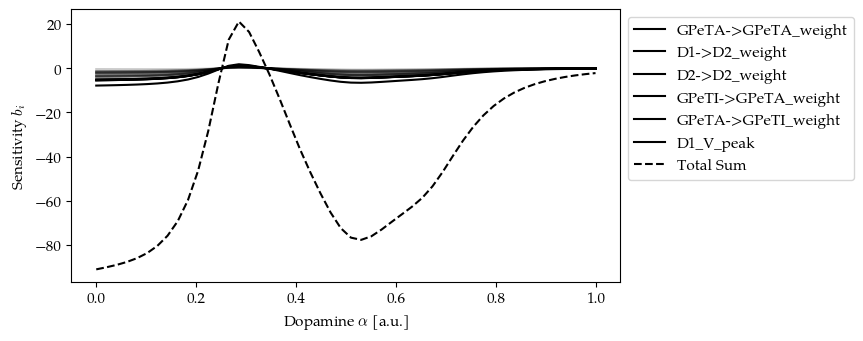

In [1284]:
plt.style.use("../style.mplstyle")
subset = relevance_df.loc[relevance_df['feature'].isin(best_feats)]
color_dict = {"GPeTA_E_l":"yellow",
              "FSN->D2_connectivity": "purple",
              "FSN->D2_connectivity": "red",
              "D2->GPeTI_weight": "blue",
              "GPeTI->GPeTI_weight": "orange",
              "GPeTI->FSN_weight": "green",
              "D2->D2_connectivity": "cyan"
              }

for bf in best_feats:
    subset = relevance_df[relevance_df.feature == bf]
    plt.plot(subset.alpha, subset.relevance, c=color_dict.get(bf, "k"), label=bf)

summ = np.zeros(len(relevance_df[relevance_df.feature == features[0]]))
summ_bests = np.zeros(len(relevance_df[relevance_df.feature == features[0]]))
summ_pippe = np.zeros(len(relevance_df[relevance_df.feature == features[0]]))

for feat in features:
    subset = relevance_df[relevance_df.feature == feat]
    summ += subset.relevance.to_numpy()
    if feat not in best_feats:
        plt.plot(subset.alpha, subset.relevance, color="k", alpha=0.2)
        summ_pippe += subset.relevance.to_numpy()

    if feat in best_feats:
        summ_bests += subset.relevance.to_numpy()

plt.plot(subset.alpha, summ, color="k", ls="--", label="Total Sum")
# plt.plot(subset.alpha, summ_bests, color="k", ls=":", label="Summ best")
# plt.plot(subset.alpha, summ_pippe, color="r", ls="--", label="Summ best")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel(r"Dopamine $\alpha$ [a.u.]")
plt.ylabel(r"Sensitivity $b_i$")

plt.savefig("relevance_alpha.pdf", bbox_inches='tight')

In [1285]:
mask = (subset.alpha > 0.3 ) & (subset.alpha < 0.6)
aa = subset.alpha[mask].to_numpy()
bb = summ[mask]

aa[np.argmax(bb)]

0.3061224489795918

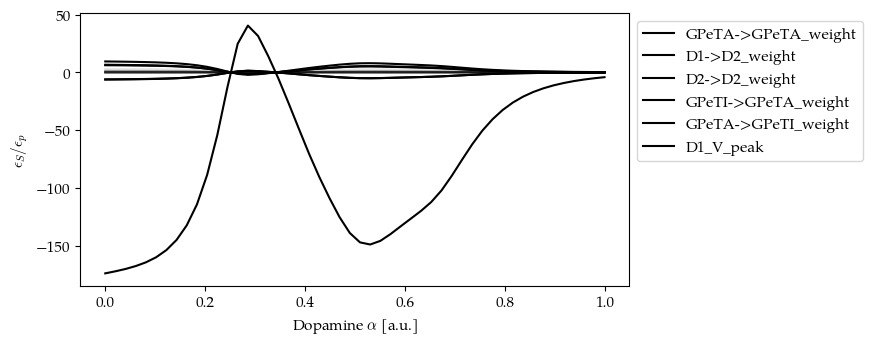

In [1286]:
plt.style.use("../style.mplstyle")
subset = relevance_df.loc[relevance_df['feature'].isin(best_feats)]
color_dict = {"GPeTA_E_l":"yellow",
              "FSN->D2_connectivity": "purple",
              "FSN->D2_connectivity": "red",
              "D2->GPeTI_weight": "blue",
              "GPeTI->GPeTI_weight": "orange",
              "GPeTI->FSN_weight": "green",
              "D2->D2_connectivity": "cyan"
              }

for bf in best_feats:
    subset = relevance_df[relevance_df.feature == bf]
    plt.plot(subset.alpha, subset.relevance/new_parameters_dict['parametric'][bf][0]['susceptibility'], 
             c=color_dict.get(bf, "k"), 
             label=bf)

for feat in features:
    if feat not in best_feats:
        subset = relevance_df[relevance_df.feature == feat]
        plt.plot(subset.alpha, subset.relevance/new_parameters_dict['parametric'][feat][0]['susceptibility']/subset.function_value, color="k", alpha=0.1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel(r"Dopamine $\alpha$ [a.u.]")
plt.ylabel(r"$\epsilon_S /\epsilon_p$")
plt.savefig("relevance_alpha_weighted.pdf", bbox_inches='tight')

### Model independent

In [100]:
def gradient_from_irregular(points, function_evaluations):
    M = len(points)     # Number of points
    L = int(M*(M-1)/2)  # Number of couples
    dim = points.shape[1]
    
    Delta = np.zeros((L, X.shape[1]))
    B = np.zeros(L)
    # print(f"Estimating gradient on {L} couples")
    couples = 0
    couples_dict = dict()
    for i in range(M*M):
        couple_index = i + 1
        point_1 = couple_index // M
        point_2 = couple_index % M
        
        if point_1 >= point_2:
            continue
            
        if (X[point_1] == X[point_2]).all():
            print("Skipped duplicate")
            continue
        
        for dim in range(X.shape[1]):
            Delta[couples, dim] = X[point_2, dim] - X[point_1, dim] 
        norm = np.sqrt(np.sum(Delta[couples]**2))
        if norm == 0:
            raise ValueError("Norm is null in irregular grad")
            
        Delta[couples] /= norm
        B[couples] = (function_evaluations[point_2] - function_evaluations[point_1])/norm
        
        couples_dict[couples] = (point_1, point_2)
        couples +=1

    # Estimate the gradient through inverse
    invmat = np.matmul( np.linalg.inv( np.matmul( Delta.T , Delta)), Delta.T)
    grad = invmat.dot(B)
    return grad

In [101]:
pop = "STN"
analysis_feature1 = "beta_power"
analysis_feature2 = "low_gamma_power"
analysis_feature3 = "high_gamma_power"

y = data[f"{pop}_{analysis_feature1}"].to_numpy()

In [151]:
data_good = data[data.alpha > 0.6]
data_good = data_good.drop(columns = ["SNR_high_gamma_power", "SNR_entropy", "SNR_mean_fr"])
# print(data_good.columns)
par_cols = ['FSN_E_l', 'GPeTI_E_l', 'GPeTA_E_l', 'D1_V_peak', 'D1_ada_b',
       'FSN->FSN_weight', 'GPeTA->FSN_weight', 'GPeTI->FSN_weight',
       'GPeTA->GPeTA_weight', 'GPeTA->GPeTI_weight', 'GPeTI->GPeTI_weight',
       'GPeTI->GPeTA_weight', 'D2->GPeTI_weight', 'STN->GPeTA_weight',
       'STN->GPeTI_weight', 'FSN->D2_connectivity', 'D1->D1_connectivity',
       'D1->D2_connectivity', 'D2->D1_connectivity', 'D2->D2_connectivity',
       'D1->D1_weight', 'D1->D2_weight', 'D2->D1_weight', 'D2->D2_weight',
       'GPeTA->D1_weight',  'GPeTI->STN_weight']
obs_col = 'STN_beta_power'
display(data_good)

,FSN_E_l,GPeTI_E_l,GPeTA_E_l,D1_V_peak,D1_ada_b,SNR_E_l,FSN->FSN_weight,GPeTA->FSN_weight,GPeTI->FSN_weight,GPeTA->GPeTA_weight,...,STN_entropy,STN_mean_fr,SNR_fmax,SNR_fmean,SNR_norm_beta_power,SNR_norm_low_gamma_power,SNR_norm_high_gamma_power,SNR_beta_power,SNR_low_gamma_power,alpha
180,0.630173,0.628285,0.601144,0.609059,0.611968,0.638896,0.599161,0.599538,0.607768,0.602092,...,5.967261,14.857843,16.0,16.517274,0.491927,0.101489,0.140466,660.939648,136.358110,0.619283
181,0.624315,0.626985,0.631579,0.629622,0.641234,0.602683,0.639074,0.608144,0.630398,0.621755,...,5.076316,14.858824,16.0,16.455425,0.537824,0.183959,0.120505,1883.019042,644.072989,0.625707
182,0.620448,0.637822,0.631871,0.625532,0.615227,0.638259,0.596195,0.642749,0.598345,0.624773,...,4.927496,14.939706,16.0,16.313028,0.560454,0.167841,0.125252,2221.924396,665.406477,0.623876
183,0.644121,0.635925,0.620906,0.599788,0.640173,0.610188,0.599066,0.603213,0.598401,0.623561,...,5.380715,15.057353,16.0,16.583427,0.519485,0.161985,0.135844,1378.120748,429.723384,0.617014
184,0.620119,0.632528,0.630564,0.640575,0.631076,0.638356,0.613705,0.597551,0.624078,0.603956,...,4.827244,14.800000,16.0,16.349623,0.512138,0.190986,0.142842,1952.173514,728.001478,0.623648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.995648,0.985301,0.986218,0.978879,0.975129,0.978329,0.995754,0.985686,0.983405,0.975597,...,6.718678,13.062745,17.0,19.756261,0.133985,0.096432,0.202419,8.743478,6.292878,0.987441
596,0.994591,0.985907,0.989595,0.999548,0.990396,0.987055,0.999510,0.975994,0.981399,0.982382,...,6.680867,13.128922,18.0,18.550161,0.160346,0.078741,0.225462,12.979251,6.373728,0.988380
597,0.977387,0.989476,0.975771,0.982518,0.978873,0.978420,0.990796,0.977229,0.982969,0.979651,...,6.690192,13.061765,15.5,17.723698,0.171371,0.075189,0.217133,16.313351,7.157426,0.984726
598,0.980337,0.989728,0.980624,0.990903,0.978260,0.999534,0.978534,0.985952,0.987784,0.980761,...,6.718957,13.199510,16.5,18.078834,0.127799,0.086896,0.230851,11.414254,7.761022,0.984890


In [152]:
X = data_good.drop(columns=["alpha"])[par_cols].to_numpy()
y = data_good[obs_col].to_numpy()
grad = gradient_from_irregular(X, y)
param_sensitivity = np.zeros(grad.shape)

for i, feat in enumerate(par_cols):
    print(feat,  grad[i])
    param_sensitivity[i] = grad[i]/new_parameters_dict['parametric'][feat][0]['susceptibility']

FSN_E_l -4.287200021411406

GPeTI_E_l 0.34971517651582806

GPeTA_E_l 0.24218785816368266

D1_V_peak 0.21702782852200075

D1_ada_b -2.798672496357706

FSN->FSN_weight 1.9219749871878404

GPeTA->FSN_weight 0.27333887562812514

GPeTI->FSN_weight -0.5487370578651528

GPeTA->GPeTA_weight 0.38930828844303256

GPeTA->GPeTI_weight -0.404615246285007

GPeTI->GPeTI_weight 4.125678579058794

GPeTI->GPeTA_weight 2.0839375407958936

D2->GPeTI_weight -3.712345395592265

STN->GPeTA_weight -4.271004179830812

STN->GPeTI_weight -0.09383180462770052

FSN->D2_connectivity -0.6548670714576765

D1->D1_connectivity 1.4811747930002575

D1->D2_connectivity 0.5300509164588798

D2->D1_connectivity 0.3159768041627305

D2->D2_connectivity -2.3558880892091185

D1->D1_weight 0.2520718539240521

D1->D2_weight -1.3089774541674548

D2->D1_weight -0.12231161129535616

D2->D2_weight -5.086401947209168

GPeTA->D1_weight 4.511019754471038

GPeTI->STN_weight 0.3278134530928688

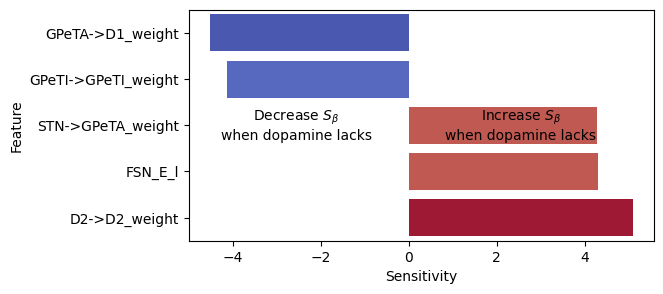

In [153]:
grad_df = pd.DataFrame(dict(Sensitivity=-grad, 
                            Feature=par_cols,
                            ParSens=-param_sensitivity,
                            abs_sensitivity=np.abs(grad)))
grad_df = grad_df.nlargest(5, "abs_sensitivity")
grad_df = grad_df.sort_values(by="Sensitivity")
fig, ax = plt.subplots(figsize=(6, 3))
xx = np.max(np.abs(grad_df.Sensitivity))/2
sns.barplot(data=grad_df, y="Feature", x="Sensitivity", hue="Sensitivity", palette="coolwarm", legend=False)
plt.annotate(r"Decrease $S_\beta$" + "\nwhen dopamine lacks", (-xx, len(grad_df)//2), va="center", ha="center")
plt.annotate(r"Increase $S_\beta$" + "\nwhen dopamine lacks", (xx, len(grad_df)//2), va="center", ha="center")
plt.savefig("global_relevance.pdf",bbox_inches='tight' )



In [150]:
grad_df = pd.DataFrame(dict(Sensitivity=grad, 
                            Feature=features,
                            ParSens=param_sensitivity,
                            abs_sensitivity=np.abs(grad),
                            abs_parsens=np.abs(param_sensitivity)))
grad_df = grad_df.nlargest(10, "abs_parsens")
grad_df = grad_df.sort_values(by="ParSens")

xx = np.max(np.abs(grad_df.ParSens))/2

bp = sns.barplot(data=grad_df, y="Feature", x="ParSens", hue="ParSens", palette="coolwarm_r", legend=False)
bp.set_xlabel("Parameter Sensitivity")

# norm = plt.Normalize(grad_df.Sensitivity.min(), grad_df.Sensitivity.max())
# sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
# cbar = ax.figure.colorbar(sm, ax=bp)
# cbar.set_label("Dopamine sensitivity")


ValueError: All arrays must be of the same length